In [1]:
# # Restuccia & Rogerson (2008) - Replication Notebook (All Tables & Figure)
#
# This notebook reproduces the benchmark and distortion experiments in:
# Restuccia, D. & Rogerson, R. (2008), "Policy distortions and aggregate productivity with heterogeneous establishments"
# **Review of Economic Dynamics**, 11(4), 707-720.
#
# Outputs:
# - Tables 1-9 (printed inline and optionally exported to LaTeX under `./tables/`)
# - Figure 1 (distribution fit; saved under `./figures/`)
# - Welfare and sample path tables from the transition wrapper
# - Graphs plotting transition paths for various preferences, explict entry/exit, unanticipated shocks
#
# Notes:
# - If `establishment_dist.txt` is present (2 columns: upper bound of employment bin, share-of-establishments),
#   it will be used to fit the establishment distribution like the original code.
# - Otherwise, a fallback using Table 2 targets is used to keep the notebook fully runnable.

In [ ]:
# 1) Imports & global config
import os
import math
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, Tuple, Optional

np.set_printoptions(precision=6, suppress=True)

# Output folders
TABLE_DIR = "tables"
FIG_DIR = "figures"
os.makedirs(TABLE_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

# Helper: clean print
def hr(title=""):
    print("\n" + "="*80)
    if title:
        print(title)
        print("-"*80)

In [3]:

# 2) Parameters & model containers

@dataclass
class Calib:
    # Production
    alpha: float = 0.85/3   # capital share
    gamma: float = 0.85/3 * 2   # labor share
    beta: float  = 0.96
    delta: float = 0.08
    S: float     = 1.0     # scale

    # Entry/exit & costs
    ce: float    = 1.0     # entry cost (normalization)
    cf: float    = 0.0     # operating fixed cost (benchmark: 0)
    lam: float   = 0.10    # exit probability (lambda)

    # Grids
    ns: int      = 100     # productivity points
    ntau: int    = 3       # tax states: [-taus, 0, +tau]

    # Productivity bounds (via employment range mapped to s)
    # From paper: employment range ~ [1, 10,000] [rightwards_arrow] s in [1, 3.98]
    s_min: float  = 1.0
    s_max: float  = 3.98

    # Experiments
    tau_vec: Tuple[float, ...] = (0.0, 0.1, 0.2, 0.3, 0.4)  # includes benchmark 0.0


@dataclass
class State:
    # Endogenous prices & aggregates
    r: float = 0.0       # rental (gross) in steady state
    i: float = 0.0       # user cost: r - delta
    w: float = 0.0       # wage
    Kbe: float = 0.0     # benchmark K (for capital-preserving experiments)

    # Grids
    s: Optional[np.ndarray] = None          # (ns,)
    z: Optional[np.ndarray] = None          # employment mapping grid (ns,)
    hs: Optional[np.ndarray] = None         # density over s (ns,)
    g: Optional[np.ndarray] = None          # joint density over (s, tau) (ns, ntau)
    smatrix: Optional[np.ndarray] = None    # S*s tiled over tau (ns, ntau)
    mtauo: Optional[np.ndarray] = None      # output tax matrix (ns, ntau)
    mtauk: Optional[np.ndarray] = None      # capital tax matrix (ns, ntau)
    mtaun: Optional[np.ndarray] = None      # labor tax matrix (ns, ntau)

    # Policies / decisions
    kbar: Optional[np.ndarray] = None   # (ns, ntau)
    nbar: Optional[np.ndarray] = None   # (ns, ntau)
    xbar: Optional[np.ndarray] = None   # entry/operate indicator (ns, ntau)

    # Invariant distribution & aggregates
    E: float = 0.0
    N: float = 0.0
    mu: Optional[np.ndarray] = None     # (ns, ntau)

In [4]:

# 3) Establishment distribution fitting (Fig. 1)

def load_or_construct_distribution(cal: Calib) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Returns: z (employment grid proxy), s grid, hs density (ns,), data for plotting (data_zup, data_Hs)
    If 'establishment_dist.txt' exists (two columns: z_upper, share), fit like original MATLAB.
    Otherwise fallback to 3-bin distribution matching Table 2 shares: establishments <5, 5-49, >=50.
    """
    alpha, gamma = cal.alpha, cal.gamma

    # steady-state employment mapping (benchmark, undistorted):
    # In the benchmark, relative labor demand n_i / n_j = (s_i / s_j)^(1/(1-alpha-gamma))
    s = np.logspace(np.log10(cal.s_min), np.log10(cal.s_max), cal.ns)
    z = s**(1.0/(1.0 - cal.alpha - cal.gamma))  # proportional to employment in benchmark

    data_file = "establishment_dist.txt"
    if os.path.exists(data_file):
        # Expect two columns: datazupper, datahs
        dat = np.loadtxt(data_file)
        data_zup = dat[:, 0]       # bin upper bounds in employees
        data_hs  = dat[:, 1]       # share of establishments per bin (must sum to ~1)
        # Fit hs on s-grid by spreading each bin's mass uniformly across points with z in that bin
        hs = np.zeros_like(s)
        data_zup2 = np.concatenate(([0.0], data_zup))
        for i in range(1, len(data_zup2)):
            mask = (z <= data_zup2[i]) & (z > data_zup2[i-1])
            if mask.sum() > 0:
                hs[mask] = data_hs[i-1] / mask.sum()
        # Empirical CDF from bins for plotting:
        data_Hs = np.cumsum(data_hs)
        return z, s, hs, (data_zup, data_Hs)
    else:
        # Fallback: Table 2 (shares of establishments by size)
        # Establishment size bins: <5, 5-49, >=50
        # Shares of establishments: 0.56, 0.39, 0.05  (Table 2)
        cut1, cut2 = 5, 50
        bin_shares = np.array([0.56, 0.39, 0.05])
        hs = np.zeros_like(s)
        mask1 = (z < cut1)
        mask2 = (z >= cut1) & (z < cut2)
        mask3 = (z >= cut2)
        for mask, share in zip([mask1, mask2, mask3], bin_shares):
            cnt = mask.sum()
            if cnt > 0:
                hs[mask] = share / cnt
        # Synthetic data for plotting CDF:
        data_zup = np.array([cut1, cut2, z.max()])
        data_Hs  = np.cumsum(bin_shares)
        return z, s, hs, (data_zup, data_Hs)

In [5]:

# 4) Core model functions (vectorized)

def steady_prices(cal: Calib) -> Tuple[float, float]:
    """Compute steady-state rental & user cost from beta, delta (consumer FOC)."""
    # r is gross rental: r = 1/beta - (1 - delta); user cost i = r - delta
    r = 1.0 / cal.beta - (1.0 - cal.delta)
    i = r - cal.delta
    return r, i

def plant_decisions(cal: Calib, st: State, w: float) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Given taxes (mtauo, mtauk, mtaun), smatrix and prices (w, r),
    compute kbar(s,tau), nbar(s,tau), profits pibar(s,tau) and entry indicator xbar(s,tau).
    """
    a, g = cal.alpha, cal.gamma
    r = st.r

    eps = 1e-12
    one_minus_tauo = (1.0 - st.mtauo)
    one_plus_tauk  = (1.0 + st.mtauk)
    one_plus_taun  = (1.0 + st.mtaun)

    # Capital demand
    # k* = [ (alpha/(r(1+tau_k)))^((1-gamma)/(1-alpha-gamma)) * (gamma/(w(1+tau_n)))^(gamma/(1-alpha-gamma)) * (s*(1-tau_o))^(1/(1-alpha-gamma)) ]
    pow1 = (1.0 - g)/(1.0 - a - g)
    pow2 = g/(1.0 - a - g)
    pow3 = 1.0/(1.0 - a - g)

    kbar = ( (a / (r * one_plus_tauk + eps))**pow1
            * (g / (w * one_plus_taun + eps))**pow2
            * (st.smatrix * one_minus_tauo)**pow3 )

    # Labor from FOC mapping in original code:
    # n* = ((1+tau_k) r gamma)/((1+tau_n) w alpha) * kbar
    nbar = (one_plus_tauk * r * g) / (one_plus_taun * w * a + eps) * kbar

    # Profit per period (before entry/operate decision):
    pibar = (one_minus_tauo) * st.smatrix * (kbar**a) * (nbar**g) \
            - one_plus_taun * w * nbar \
            - one_plus_tauk * r * kbar \
            - cal.cf

    # Value W(s,tau) = pibar / (1 - rho), rho = (1-lambda)/(1+i)
    rho = (1.0 - cal.lam) / (1.0 + st.i)
    W = pibar / max(1e-12, (1.0 - rho))

    # Entry/operate decision (xbar=1 if W >= 0)
    xbar = (W >= 0.0).astype(float)

    return kbar, nbar, xbar

def Wefcn(w: float, cal: Calib, st: State) -> float:
    """
    Entrant's expected value net of entry cost: We = sum(W*g*xbar) - ce.
    But we don't explicitly compute W here again—mirror MATLAB logic:
      - compute decisions at given w
      - compute pibar and then W to build We
    """
    a, g = cal.alpha, cal.gamma
    r = st.r

    kbar, nbar, xbar = plant_decisions(cal, st, w)

    # recompute profits
    one_minus_tauo = (1.0 - st.mtauo)
    one_plus_tauk  = (1.0 + st.mtauk)
    one_plus_taun  = (1.0 + st.mtaun)

    pibar = (one_minus_tauo) * st.smatrix * (kbar**a) * (nbar**g) \
            - one_plus_taun * w * nbar \
            - one_plus_tauk * r * kbar \
            - cal.cf

    rho = (1.0 - cal.lam) / (1.0 + st.i)
    W = pibar / max(1e-12, (1.0 - rho))
    We = (W * st.g * xbar).sum() - cal.ce

    st.kbar, st.nbar, st.xbar = kbar, nbar, xbar
    return float(We)

def solve_wage_by_bisection(cal: Calib, st: State, w0=1.0, w1=1.5, tol=1e-7, maxit=100) -> float:
    """
    Finds w s.t. entrant's zero profit condition holds: We(w) = 0.
    Matches the MATLAB bisection structure and expands bracket if needed.
    """
    We0 = Wefcn(w0, cal, st)
    We1 = Wefcn(w1, cal, st)

    # Expand bracket if not bracketing root
    expand_it = 0
    while We0 * We1 > 0 and expand_it < 40:
        if We0 < 0:
            w0 *= 0.5
            We0 = Wefcn(w0, cal, st)
        if We1 > 0:
            w1 *= 1.5
            We1 = Wefcn(w1, cal, st)
        expand_it += 1

    # Bisection
    for it in range(maxit):
        w = 0.5 * (w0 + w1)
        We = Wefcn(w, cal, st)
        if abs(We) < tol:
            return w
        if We * We1 > 0:
            w1 = w
            We1 = We
        else:
            w0 = w
            We0 = We
    # If not converged:
    return w

def invariant_and_aggregates(cal: Calib, st: State) -> Dict[str, float]:
    # normalized mu-hat for E=1:
    muhat = (1.0 / cal.lam) * st.xbar * st.g  # (ns, ntau)

    # Labor market clearing gives E:
    N = (st.nbar * muhat).sum()
    E = 1.0 / max(1e-12, N)

    mu = muhat * E
    st.mu = mu
    st.E = E
    st.N = N

    # Aggregates:
    Y = (st.smatrix * (st.kbar**cal.alpha) * (st.nbar**cal.gamma) * mu).sum()
    K = (st.kbar * mu).sum()
    M = mu.sum()
    # "employment" in paper's notation: N*E equals total workers (=1). Our E*N=1 by construction.
    # TFP: A = Y / ( (K)^{alpha} * (N*E)^{gamma} ), but N*E=1 [rightwards_double_arrow] A = Y / (K^alpha)
    # For clarity use: A = Y / ((K)**cal.alpha * (1.0)**cal.gamma)
    A = Y / (max(1e-12, K)**cal.alpha)

    return dict(Y=Y, K=K, M=M, A=A, E=E, N=N, w=st.w)


In [6]:

# 5) Distortion builders & capital-preserving tau_s search

def set_tax_matrices(cal: Calib, st: State, tau: float, taus: float, base: str = "output"):
    ns, ntau = cal.ns, cal.ntau
    tauv = np.array([-taus, 0.0, tau])

    mtau = np.broadcast_to(tauv.reshape(1, ntau), (ns, ntau))

    if base == "output":
        st.mtauo = mtau
        st.mtauk = np.zeros_like(mtau)
        st.mtaun = np.zeros_like(mtau)
    elif base == "capital":
        st.mtauo = np.zeros_like(mtau)
        st.mtauk = mtau
        st.mtaun = np.zeros_like(mtau)
    elif base == "labor":
        st.mtauo = np.zeros_like(mtau)
        st.mtauk = np.zeros_like(mtau)
        st.mtaun = mtau
    else:
        raise ValueError("base must be one of {'output','capital','labor'}")

def set_joint_density(cal: Calib, st: State, hs: np.ndarray, mode: str,
                      sub: float, nosub: float) -> None:
    """
    Sets st.g (ns,ntau)
    mode:
      - "benchmark": all mass in middle column (τ=0)
      - "iid": iid case (uncorrelated) with probabilities [sub, nosub, 1-sub-nosub]
      - "corr_low_sub": correlated, subsidize lowest productivity mass 'sub', tax the rest (some mass can be nosub)
      - "corr_high_sub": correlated, subsidize highest productivity mass 'sub', tax the rest
    """
    ns, ntau = cal.ns, cal.ntau
    hsmatrix = hs.reshape(-1, 1) * np.ones((1, ntau))
    g = np.zeros_like(hsmatrix)

    if mode == "benchmark":
        probs = np.array([0.0, 1.0, 0.0])
        g = hsmatrix * probs
    elif mode == "iid":
        probs = np.array([sub, nosub, max(0.0, 1.0 - sub - nosub)])
        g = hsmatrix * probs
    elif mode == "corr_low_sub":
        # cumsum over s to assign lowest productivity to subsidies
        cum = np.cumsum(hs)
        g[:, :] = 0.0
        g[cum <= sub, 0] = hs[cum <= sub]                # subsidized low s
        if nosub > 0:
            mask_mid = (cum > sub) & (cum <= sub + nosub)
            g[mask_mid, 1] = hs[mask_mid]               # no distort
        g[cum > (sub + nosub), 2] = hs[cum > (sub + nosub)]  # taxed
    elif mode == "corr_high_sub":
        cum = np.cumsum(hs)
        g[:, :] = 0.0
        g[cum <= 1.0 - sub - nosub, 2] = hs[cum <= 1.0 - sub - nosub]  # taxed low s
        if nosub > 0:
            mask_mid = (cum > 1.0 - sub - nosub) & (cum <= 1.0 - sub)
            g[mask_mid, 1] = hs[mask_mid]
        g[cum > 1.0 - sub, 0] = hs[cum > 1.0 - sub]     # subsidized high s
    else:
        raise ValueError("Unknown mode for joint density.")

    st.g = g

def wage_and_aggregates_for_policy(cal: Calib, st: State, tax_base: str, tau: float, taus: float) -> Dict[str, float]:
    set_tax_matrices(cal, st, tau=tau, taus=taus, base=tax_base)
    # Solve wage from zero-profit (entry) condition
    w = solve_wage_by_bisection(cal, st)
    st.w = w
    # Compute aggregates
    aggs = invariant_and_aggregates(cal, st)
    return aggs

def choose_taus_to_preserve_K(cal: Calib, st: State, tax_base: str, tau: float,
                              taus_lo: float, taus_hi: float,
                              tol=1e-7, maxit=100) -> Tuple[float, Dict[str, float]]:
    """
    Bisection in τ_s to keep K = Kbe (benchmark capital stock).
    Returns (taus*, aggregates at that taus*).
    """
    # Evaluate residual at bounds:
    a_lo = wage_and_aggregates_for_policy(cal, st, tax_base, tau, taus_lo)
    res_lo = a_lo["K"] - st.Kbe

    a_hi = wage_and_aggregates_for_policy(cal, st, tax_base, tau, taus_hi)
    res_hi = a_hi["K"] - st.Kbe

    if res_lo * res_hi > 0:
        # No root bracketed; return best of two and warn softly
        # Protects against some strange choices of tau
        if abs(res_lo) <= abs(res_hi):
            return taus_lo, a_lo
        else:
            return taus_hi, a_hi

    lo, hi = taus_lo, taus_hi
    a_mid = None
    for _ in range(maxit):
        mid = 0.5*(lo+hi)
        a_mid = wage_and_aggregates_for_policy(cal, st, tax_base, tau, mid)
        res = a_mid["K"] - st.Kbe
        if abs(res) < tol:
            return mid, a_mid
        if res * res_hi > 0:
            hi, a_hi, res_hi = mid, a_mid, res
        else:
            lo, a_lo, res_lo = mid, a_mid, res
    return mid, a_mid

In [7]:

# 6) Benchmark economy (tau=0)

def run_benchmark(cal: Calib, st: State, hs: np.ndarray) -> Dict[str, float]:
    # No distortions; all mass in middle tau=0
    set_joint_density(cal, st, hs, mode="benchmark", sub=0.0, nosub=0.0)
    set_tax_matrices(cal, st, tau=0.0, taus=0.0, base="output")
    # Solve wage
    w = solve_wage_by_bisection(cal, st)
    st.w = w
    # Aggregates
    aggs = invariant_and_aggregates(cal, st)
    st.Kbe = aggs["K"]  # store benchmark K
    return aggs

In [8]:

# 7) Experiment runners & table builders

def shares_by_bins(cal: Calib, st: State, bins=(5, 50)) -> Dict[str, np.ndarray]:
    mu = st.mu
    ns, ntau = mu.shape
    # aggregate measures by (s, tau)
    output_st = st.smatrix * (st.kbar**cal.alpha) * (st.nbar**cal.gamma) * mu
    labor_st  = st.nbar * mu
    capital_st= st.kbar * mu

    try:
        norm_emp = st.nbar[0, 1]
        rnbar = st.nbar / max(1e-12, norm_emp)
    except Exception:
        rnbar = st.nbar

    # "employment" proxy for bin membership uses rnbar in tau=0 (middle column):
    n_mid = rnbar[:, 1] if st.nbar.shape[1] >= 2 else rnbar.mean(axis=1)

    bins_edges = [0, bins[0], bins[1], np.inf]
    masks = [(n_mid < bins[0]),
             (n_mid >= bins[0]) & (n_mid < bins[1]),
             (n_mid >= bins[1])]

    mu_s = mu.sum(axis=1)
    out_s= output_st.sum(axis=1)
    lab_s= labor_st.sum(axis=1)
    cap_s= capital_st.sum(axis=1)

    M = mu_s.sum()
    Y = out_s.sum()
    L = lab_s.sum()
    K = cap_s.sum()

    est_shares = np.array([mu_s[m].sum()/M for m in masks])
    out_shares = np.array([out_s[m].sum()/Y for m in masks])
    lab_shares = np.array([lab_s[m].sum()/L for m in masks])
    cap_shares = np.array([cap_s[m].sum()/K for m in masks])

    # Average employment per plant in bin
    avg_emp = []
    for m in masks:
        Me = mu_s[m].sum()
        Le = lab_s[m].sum()
        avg_emp.append(Le / max(1e-12, Me))
    avg_emp = np.array(avg_emp)

    return dict(est=est_shares, out=out_shares, lab=lab_shares, cap=cap_shares, avg_emp=avg_emp)

def summarize_relative(bench: Dict[str, float], aggs: Dict[str, float]) -> Dict[str, float]:
    rel = {}
    for k in ("Y","A","E","M","w"):
        rel[k] = aggs[k] / bench[k]
    return rel

def subsidy_stats(cal: Calib, st: State, aggs: Dict[str, float]) -> Dict[str, float]:
    # Ys: output of subsidized state (col 0)
    Y_all = (st.smatrix * (st.kbar**cal.alpha) * (st.nbar**cal.gamma) * st.mu).sum()
    Ys    = (st.smatrix[:, 0] * (st.kbar[:, 0]**cal.alpha) * (st.nbar[:, 0]**cal.gamma) * st.mu[:, 0]).sum()

    # Compute "fiscal outlays" depending on tax base:
    if np.abs(st.mtauo).sum() > 0:
        # Output base
        # Taxes/subsidies (negative tau is subsidy): revenue = sum(tau * Y_i)
        rev = (st.mtauo * st.smatrix * (st.kbar**cal.alpha) * (st.nbar**cal.gamma) * st.mu).sum()
        S_over_Y = - rev / max(1e-12, Y_all)
    elif np.abs(st.mtauk).sum() > 0:
        # Capital base: revenue = sum(tau_k * r * k_i)
        rev = (st.mtauk * st.r * st.kbar * st.mu).sum()
        S_over_Y = - rev / max(1e-12, Y_all)
    elif np.abs(st.mtaun).sum() > 0:
        # Labor base: revenue = sum(tau_n * w * n_i)
        rev = (st.mtaun * st.w * st.nbar * st.mu).sum()
        S_over_Y = - rev / max(1e-12, Y_all)
    else:
        S_over_Y = 0.0

    return dict(Ys_over_Y=Ys/max(1e-12,Y_all), S_over_Y=S_over_Y)


In [9]:

# 8) LaTeX export helpers (separate from core logic)

def to_latex_table(df: pd.DataFrame, caption: str, label: str, fname: str,
                   float_format="%.2f", index=True):
    tex = df.to_latex(float_format=float_format, caption=caption, label=label, index=index, escape=False)
    path = os.path.join(TABLE_DIR, fname)
    with open(path, "w", encoding="utf-8") as f:
        f.write(tex)


In [10]:

# 9) Initialize calibration, grids, and benchmark run

cal = Calib()

st = State()
st.r, st.i = steady_prices(cal)

z, s, hs, data_fit = load_or_construct_distribution(cal)
st.s = s
st.z = z
st.smatrix = cal.S * s.reshape(-1, 1) * np.ones((1, cal.ntau))

# Benchmark
bench_aggs = run_benchmark(cal, st, hs)

hr("Benchmark Economy (Table 1 inputs, Table 2 outputs)")
print({k: v for k, v in bench_aggs.items() if k in ("Y","A","K","E","M","w")})

# Table 1: Benchmark calibration to U.S. data 

params_data = {
    "Parameter": ["α", "γ", "β", "δ", "λ", "ce", "cf", "S range"],
    "Value": [
        cal.alpha,
        cal.gamma,
        cal.beta,
        cal.delta,
        cal.lam,
        cal.ce,
        cal.cf,
        f"[{cal.s_min}, {cal.s_max}]"
    ],
    "Target": [
        "Capital income share",
        "Labor income share",
        "Real rate of return",
        "Investment/output ratio",
        "Annual exit rate",
        "Normalization",
        "Benchmark case",
        "Relative establishment sizes"
    ]
}

df_tab1 = pd.DataFrame(params_data).set_index("Parameter")

hr("Table 1 — Benchmark calibration to U.S. data")
display(df_tab1)

# Export LaTeX (for completeness)
to_latex_table(
    df_tab1,
    "Benchmark calibration to U.S. data",
    "tab:benchmark_calib",
    "table1_benchmark_calibration.tex",
    float_format="%.3f",
    index=True
)


# Distribution statistics (Table 2)
tab2 = shares_by_bins(cal, st, bins=(5,50))
df_tab2 = pd.DataFrame({
    "Share of establishments": tab2["est"],
    "Share of output": tab2["out"],
    "Share of labor": tab2["lab"],
    "Share of capital": tab2["cap"],
    "Average employment": tab2["avg_emp"]
}, index=["< 5", "5 to 49", "≥ 50"])
hr("Table 2 — Distribution statistics of benchmark economy")
display(df_tab2)
to_latex_table(df_tab2, "Distribution statistics of benchmark economy",
               "tab:dist_benchmark", "table2_benchmark.tex", float_format="%.2f", index=True)


Benchmark Economy (Table 1 inputs, Table 2 outputs)
--------------------------------------------------------------------------------
{'Y': np.float64(5.400061865962746), 'K': np.float64(12.575486537134612), 'M': np.float64(5.955950475350134), 'A': np.float64(2.635522387262037), 'E': np.float64(0.5955950475350134), 'w': 3.0600350573658943}

Table 1 — Benchmark calibration to U.S. data
--------------------------------------------------------------------------------


,Value,Target
Parameter,,
α,0.283333,Capital income share
γ,0.566667,Labor income share
β,0.96,Real rate of return
δ,0.08,Investment/output ratio
λ,0.1,Annual exit rate
ce,1.0,Normalization
cf,0.0,Benchmark case
S range,"[1.0, 3.98]",Relative establishment sizes



Table 2 — Distribution statistics of benchmark economy
--------------------------------------------------------------------------------


,Share of establishments,Share of output,Share of labor,Share of capital,Average employment
< 5,0.56,0.012887,0.012887,0.012887,0.003864
5 to 49,0.39,0.073409,0.073409,0.073409,0.031604
≥ 50,0.05,0.913703,0.913703,0.913703,3.068203


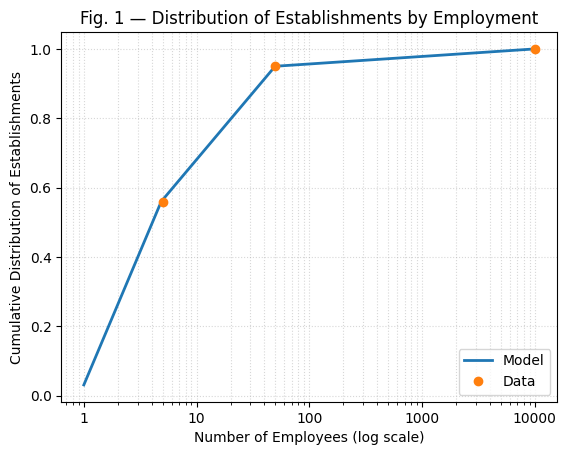

In [11]:

# 10) Figure 1: CDF of establishment sizes (model vs data)

# Model CDF from hs on z grid
model_cdf = np.cumsum(hs)

# Data CDF
data_zup, data_H = data_fit

plt.figure()
plt.semilogx(z, model_cdf, '-', linewidth=2, label="Model")
if data_zup is not None and data_H is not None:
    plt.semilogx(data_zup, data_H, 'o', label="Data")
plt.gca().set_xticks([1,10,100,1000,10000])
plt.gca().get_xaxis().set_major_formatter(plt.ScalarFormatter())
plt.xlabel("Number of Employees (log scale)")
plt.ylabel("Cumulative Distribution of Establishments")
plt.title("Fig. 1 — Distribution of Establishments by Employment")
plt.legend(loc="lower right")
plt.grid(True, which='both', linestyle=':', alpha=0.5)
plt.savefig(os.path.join(FIG_DIR, "figure1_distribution.png"), dpi=180, bbox_inches="tight")
plt.show()


In [12]:

# 11) Uncorrelated idiosyncratic distortions on OUTPUT (Table 3 & 4)

def run_uncorrelated_output(cal: Calib, hs: np.ndarray, taxed_fracs=(50,60,40,80,20,90,10)):
    """
    Table 3: 50/50 taxed/subsidized, τ_t in {0.1, 0.2, 0.3, 0.4}, τ_s chosen to keep K = K_bench
    Table 4: Relative TFP across different fractions taxed (rows) and τ_t (columns)
    """
    results_tbl3 = []
    results_tbl4 = {frac: [] for frac in [90,80,60,50,40,20,10]}

    # Table 3 configuration
    st3 = State(r=st.r, i=st.i, s=st.s, z=st.z, smatrix=st.smatrix.copy())
    set_joint_density(cal, st3, hs, mode="iid", sub=0.5, nosub=0.0)

    st3.Kbe = st.Kbe

    for tau in cal.tau_vec[1:]:  # skip 0
        # choose taus with bisection to preserve K
        taus_star, aggs = choose_taus_to_preserve_K(cal, st3, "output", tau, taus_lo=0.0, taus_hi=0.99)
        rel = summarize_relative(bench_aggs, aggs)
        subs = subsidy_stats(cal, st3, aggs)
        results_tbl3.append({
            "tau_t": tau,
            "Rel Y": rel["Y"], "Rel TFP": rel["A"], "Rel E": rel["E"], "Rel M": rel["M"], "Rel w": rel["w"],
            "Y_s/Y": subs["Ys_over_Y"], "S/Y": subs["S_over_Y"], "tau_s": taus_star
        })

    # Table 4 configuration: vary fraction taxed
    for taxed in [90,80,60,50,40,20,10]:
        # taxed% taxed, (100 - taxed)% subsidized
        sub = (100 - taxed)/100.0
        nosub = 0.0
        st4 = State(r=st.r, i=st.i, s=st.s, z=st.z, smatrix=st.smatrix.copy())
        set_joint_density(cal, st4, hs, mode="iid", sub=sub, nosub=nosub)
        st4.Kbe = st.Kbe
        row_rel_tfp = []
        for tau in cal.tau_vec[1:]:
            taus_star, aggs = choose_taus_to_preserve_K(cal, st4, "output", tau, taus_lo=0.0, taus_hi=0.99)
            row_rel_tfp.append(aggs["A"]/bench_aggs["A"])
        results_tbl4[taxed] = row_rel_tfp

    df3 = pd.DataFrame(results_tbl3).set_index("tau_t")
    df4 = pd.DataFrame(results_tbl4, index=list(cal.tau_vec[1:])).T
    df4.index.name = "Fraction taxed (%)"
    df4.columns = [f"{tau:.1f}" for tau in cal.tau_vec[1:]]

    return df3, df4

df3, df4 = run_uncorrelated_output(cal, hs)
hr("Table 3 — Uncorrelated output distortions (50/50 taxed/subsidized)")
display(df3)
to_latex_table(df3, "Aggregate variables under uncorrelated idiosyncratic output distortions",
               "tab:uncorr_output", "table3_uncorr_output.tex", float_format="%.2f", index=True)

hr("Table 4 — Relative TFP (uncorrelated distortions), varying fraction taxed")
display(df4)
to_latex_table(df4, "Relative TFP under uncorrelated idiosyncratic output distortions",
               "tab:uncorr_output_tfp", "table4_uncorr_output_tfp.tex", float_format="%.2f", index=True)



Table 3 — Uncorrelated output distortions (50/50 taxed/subsidized)
--------------------------------------------------------------------------------


,Rel Y,Rel TFP,Rel E,Rel M,Rel w,Y_s/Y,S/Y,tau_s
tau_t,,,,,,,,
0.1,0.982805,0.982805,1.0,1.0,1.0,0.719966,0.017496,0.063196
0.2,0.955146,0.955146,1.0,1.0,1.0,0.852177,0.046960,0.089799
0.3,0.931849,0.931849,1.0,1.0,1.0,0.928904,0.073135,0.101694
0.4,0.916180,0.916180,1.0,1.0,1.0,0.969811,0.091488,0.106788



Table 4 — Relative TFP (uncorrelated distortions), varying fraction taxed
--------------------------------------------------------------------------------


,0.1,0.2,0.3,0.4
Fraction taxed (%),,,,
90,0.924021,0.837717,0.776640,0.739715
80,0.951847,0.888993,0.841690,0.812004
60,0.976061,0.939519,0.909680,0.889998
50,0.982805,0.955146,0.931849,0.916180
40,0.987887,0.967549,0.949947,0.937902
20,0.995096,0.986291,0.978313,0.972687
10,0.997759,0.993625,0.989805,0.987074


In [13]:

# 12) Correlated idiosyncratic distortions on OUTPUT (Table 5 & 6)

def run_correlated_output(cal: Calib, hs: np.ndarray):
    """
    Table 5: correlated case, subsidize lowest s (50%), tax rest; τ_t ∈ {0.1,0.2,0.3,0.4}, τ_s chosen for K=K_bench
    Table 6: Relative TFP across different fractions taxed (rows) and τ_t (columns)
    """
    results_tbl5 = []
    results_tbl6 = {frac: [] for frac in [90,80,60,50,40,20,10]}

    # Table 5: 50% subsidized low s, 50% taxed
    st5 = State(r=st.r, i=st.i, s=st.s, z=st.z, smatrix=st.smatrix.copy())
    set_joint_density(cal, st5, hs, mode="corr_low_sub", sub=0.5, nosub=0.0)
    st5.Kbe = st.Kbe

    for tau in cal.tau_vec[1:]:
        taus_star, aggs = choose_taus_to_preserve_K(cal, st5, "output", tau, taus_lo=0.0, taus_hi=0.99)
        rel = summarize_relative(bench_aggs, aggs)
        subs = subsidy_stats(cal, st5, aggs)
        results_tbl5.append({
            "tau_t": tau,
            "Rel Y": rel["Y"], "Rel TFP": rel["A"], "Rel E": rel["E"], "Rel M": rel["M"], "Rel w": rel["w"],
            "Y_s/Y": subs["Ys_over_Y"], "S/Y": subs["S_over_Y"], "tau_s": taus_star
        })

    # Table 6: vary fraction taxed
    for taxed in [90,80,60,50,40,20,10]:
        sub = (100 - taxed)/100.0
        st6 = State(r=st.r, i=st.i, s=st.s, z=st.z, smatrix=st.smatrix.copy())
        set_joint_density(cal, st6, hs, mode="corr_low_sub", sub=sub, nosub=0.0)
        st6.Kbe = st.Kbe
        row_rel_tfp = []
        for tau in cal.tau_vec[1:]:
            taus_star, aggs = choose_taus_to_preserve_K(cal, st6, "output", tau, taus_lo=0.0, taus_hi=0.99)
            row_rel_tfp.append(aggs["A"]/bench_aggs["A"])
        results_tbl6[taxed] = row_rel_tfp

    df5 = pd.DataFrame(results_tbl5).set_index("tau_t")
    df6 = pd.DataFrame(results_tbl6, index=list(cal.tau_vec[1:])).T
    df6.index.name = "Fraction taxed (%)"
    df6.columns = [f"{tau:.1f}" for tau in cal.tau_vec[1:]]
    return df5, df6

df5, df6 = run_correlated_output(cal, hs)
hr("Table 5 — Correlated output distortions (subsidize low s)")
display(df5)
to_latex_table(df5, "Aggregate variables under correlated idiosyncratic output distortions (subsidize low s)",
               "tab:corr_output", "table5_corr_output.tex", float_format="%.2f", index=True)

hr("Table 6 — Relative TFP (correlated distortions), varying fraction taxed")
display(df6)
to_latex_table(df6, "Relative TFP under correlated idiosyncratic output distortions (subsidize low s)",
               "tab:corr_output_tfp", "table6_corr_output_tfp.tex", float_format="%.2f", index=True)



Table 5 — Correlated output distortions (subsidize low s)
--------------------------------------------------------------------------------


,Rel Y,Rel TFP,Rel E,Rel M,Rel w,Y_s/Y,S/Y,tau_s
tau_t,,,,,,,,
0.1,0.828255,0.828255,1.0,1.0,1.0,0.342201,0.207358,0.798181
0.2,0.684855,0.684855,1.0,1.0,1.0,0.591874,0.460162,0.915376
0.3,0.594289,0.594289,1.0,1.0,1.0,0.779314,0.682684,0.960959
0.4,0.543323,0.543323,1.0,1.0,1.0,0.899226,0.840524,0.979547



Table 6 — Relative TFP (correlated distortions), varying fraction taxed
--------------------------------------------------------------------------------


,0.1,0.2,0.3,0.4
Fraction taxed (%),,,,
90,0.917063,0.829783,0.699809,0.545076
80,0.867102,0.756207,0.623499,0.504729
60,0.808628,0.680708,0.583656,0.516365
50,0.828255,0.684855,0.594289,0.543323
40,0.842363,0.706145,0.619096,0.569730
20,0.881596,0.767067,0.690905,0.646596
10,0.903044,0.801950,0.732807,0.691870


In [14]:

# 13) Non-constant aggregate capital (Table 7 variant)

def run_exempt_tax_experiment(cal: Calib, hs: np.ndarray, tau_t=0.4, exempt_list=(10,30,50,70,90)):
    rows = []
    for exempt in exempt_list:
        st7 = State(r=st.r, i=st.i, s=st.s, z=st.z, smatrix=st.smatrix.copy())
        set_joint_density(cal, st7, hs, mode="iid", sub=0.0, nosub=exempt/100.0)

        # Set taxes
        set_tax_matrices(cal, st7, tau=tau_t, taus=0.0, base="output")

        # Solve wage and aggregates (no K preservation)
        w = solve_wage_by_bisection(cal, st7)
        st7.w = w
        aggs = invariant_and_aggregates(cal, st7)
        relY = aggs["Y"]/bench_aggs["Y"]
        relA = aggs["A"]/bench_aggs["A"]
        relE = aggs["E"]/bench_aggs["E"]
        relw = aggs["w"]/bench_aggs["w"]
        relK = aggs["K"]/bench_aggs["K"]

        # share of output produced by exempt establishments (Ys/Y)
        Y_all = (st7.smatrix * (st7.kbar**cal.alpha) * (st7.nbar**cal.gamma) * st7.mu).sum()
        Ys = (st7.smatrix[:,1] * (st7.kbar[:,1]**cal.alpha) * (st7.nbar[:,1]**cal.gamma) * st7.mu[:,1]).sum()
        rows.append({
            "Exempt (%)": exempt,
            "Rel Y": relY, "Rel TFP": relA, "Rel E": relE, "Rel w": relw, "Rel K": relK,
            "Ys/Y": Ys/max(1e-12, Y_all)
        })
    return pd.DataFrame(rows).set_index("Exempt (%)")

df7 = run_exempt_tax_experiment(cal, hs, tau_t=0.4, exempt_list=(10,30,50,70,90))
hr("Table 7 — Tax all but exempt establishments (τ_t=0.4), no capital-preserving subsidy")
display(df7)
to_latex_table(df7, "Taxing all but exempt establishments (output base, τ_t=0.4)",
               "tab:exempt_tax", "table7_exempt_tax.tex", float_format="%.2f", index=True)



Table 7 — Tax all but exempt establishments (τ_t=0.4), no capital-preserving subsidy
--------------------------------------------------------------------------------


,Rel Y,Rel TFP,Rel E,Rel w,Rel K,Ys/Y
Exempt (%),,,,,,
10,0.671889,0.783041,0.582561,0.582561,0.582561,0.667623
30,0.777129,0.845823,0.741594,0.741594,0.741594,0.885683
50,0.857574,0.901126,0.839594,0.839594,0.839594,0.947583
70,0.921854,0.945844,0.913314,0.913314,0.913314,0.976842
90,0.975828,0.983298,0.973444,0.973444,0.973444,0.993891


In [15]:

# 14) Taxes on capital and labor (Tables 8 & 9)

def run_capital_base_distortions(cal: Calib, hs: np.ndarray):
    """
    Table 8: idiosyncratic distortions to capital rental rates, uncorrelated and correlated
    Maintain K via τ_s search.
    """
    rows = []
    for mode, label in [("iid","Uncorrelated"), ("corr_low_sub","Correlated")]:
        for tau in (0.5, 1.0):
            st8 = State(r=st.r, i=st.i, s=st.s, z=st.z, smatrix=st.smatrix.copy())
            set_joint_density(cal, st8, hs, mode=mode, sub=0.5, nosub=0.0)
            st8.Kbe = st.Kbe
            taus_star, aggs = choose_taus_to_preserve_K(cal, st8, "capital", tau, taus_lo=0.0, taus_hi=0.99)
            rel = summarize_relative(bench_aggs, aggs)
            subs = subsidy_stats(cal, st8, aggs)
            rows.append({
                "Case": label, "tau_t": tau,
                "Rel Y": rel["Y"], "Rel TFP": rel["A"], "Rel E": rel["E"],
                "Y_s/Y": subs["Ys_over_Y"], "S/Y": subs["S_over_Y"], "tau_s": taus_star
            })
    df8 = pd.DataFrame(rows)
    return df8

df8 = run_capital_base_distortions(cal, hs)
hr("Table 8 — Idiosyncratic distortions to capital rental rates")
display(df8)
to_latex_table(df8.set_index(["Case","tau_t"]),
               "Idiosyncratic distortions to capital rental rates",
               "tab:capital_base", "table8_capital_base.tex", float_format="%.2f", index=True)

def run_output_vs_wages_50_50(cal: Calib, hs: np.ndarray):
    """
    Table 9: Idiosyncratic distortions—Output vs Wage base, τ_t=-τ_s=0.5, 50/50 split.
    Includes both Uncorrelated (iid) and Correlated (low-s subsidized) cases.
    """
    results = []

    for mode, label in [("iid", "Uncorrelated"), ("corr_low_sub", "Correlated")]:
        for base in ("output", "labor"):  # "labor" corresponds to wage-based distortions
            st9 = State(r=st.r, i=st.i, s=st.s, z=st.z, smatrix=st.smatrix.copy())
            set_joint_density(cal, st9, hs, mode=mode, sub=0.5, nosub=0.0)

            # tau_t = 0.5, tau_s = 0.5 (50% taxed, 50% subsidized), no K preservation
            set_tax_matrices(cal, st9, tau=0.5, taus=0.5, base=base)
            w = solve_wage_by_bisection(cal, st9)
            st9.w = w
            aggs = invariant_and_aggregates(cal, st9)
            subs = subsidy_stats(cal, st9, aggs)

            results.append({
                "Case": label,
                "Base": "Output" if base == "output" else "Wage",
                "Rel Y": aggs["Y"] / bench_aggs["Y"],
                "Rel TFP": aggs["A"] / bench_aggs["A"],
                "Rel K": aggs["K"] / bench_aggs["K"],
                "Rel E": aggs["E"] / bench_aggs["E"],
                "Rel w": aggs["w"] / bench_aggs["w"],
                "Yₛ/Y": subs["Ys_over_Y"],
                "S/Y": subs["S_over_Y"],
            })

    df9 = pd.DataFrame(results)
    df9 = df9[["Case", "Base", "Rel Y", "Rel TFP", "Rel K", "Rel E", "Rel w", "Yₛ/Y", "S/Y"]]
    return df9


df9 = run_output_vs_wages_50_50(cal, hs)

hr("Table 9 — Idiosyncratic distortions: Output vs Wage base (τ_t = −τ_s = 0.5, 50/50)")
display(df9)

to_latex_table(
    df9.set_index(["Case", "Base"]),
    "Idiosyncratic distortions — output vs wage base (τ_t = −τ_s = 0.5, 50/50)",
    "tab:output_vs_wages",
    "table9_output_vs_wages.tex",
    float_format="%.2f",
    index=True
)


hr("Done.")
print("All main tables saved to './tables'. Figure 1 saved to './figures/figure1_distribution.png'.")


Table 8 — Idiosyncratic distortions to capital rental rates
--------------------------------------------------------------------------------


,Case,tau_t,Rel Y,Rel TFP,Rel E,Y_s/Y,S/Y,tau_s
0,Uncorrelated,0.5,0.970411,0.970411,0.970411,0.739606,0.008639,0.136877
1,Uncorrelated,1.0,0.945059,0.945059,0.945059,0.832864,0.016472,0.145401
2,Correlated,0.5,0.858857,0.858857,0.858857,0.182354,0.046563,0.705520
3,Correlated,1.0,0.768431,0.768431,0.768431,0.277068,0.085384,0.705212



Table 9 — Idiosyncratic distortions: Output vs Wage base (τ_t = −τ_s = 0.5, 50/50)
--------------------------------------------------------------------------------


,Case,Base,Rel Y,Rel TFP,Rel K,Rel E,Rel w,Yₛ/Y,S/Y
0,Uncorrelated,Output,1.136636,0.977533,1.702710,1.702710,1.702710,0.998026,0.498026
1,Uncorrelated,Wage,0.844556,0.885966,0.844556,0.844556,1.671642,0.984485,0.554944
2,Correlated,Output,0.461268,0.528758,0.617579,0.617579,0.617579,0.838872,0.338872
3,Correlated,Wage,0.636306,0.723259,0.636306,0.636306,0.759537,0.395250,0.109745



Done.
--------------------------------------------------------------------------------
All main tables saved to './tables'. Figure 1 saved to './figures/figure1_distribution.png'.


## 15) Transition dynamics extension
This section keeps the replication above **unchanged** and adds a self-contained block to:
1. Build three policy/distortion scenarios (abrupt removal, partial relaxation, new distortion);
2. Map each scenario to a time path for the TFP-like object implied by the RR static model;
3. Embed that in a simple one-sector CRRA growth environment with the same $(\alpha, \beta, \delta)$ as above;
4. Shoot on initial consumption to generate capital, consumption, and interest-rate paths;
5. Compute welfare (and consumption-equivalent comparisons) for multiple values of $\sigma$.
Nothing above is altered; this just **uses** the objects (`cal`, `st`, `hs`, core functions) that the replication already defined.


In [ ]:

# 15) Transition dynamics extension

import numpy as np
import pandas as pd

# helpers to pull a "static RR economy" aggregate given a distortion

def rr_static_from_spec(cal: Calib, hs: np.ndarray, spec: dict):
    """
    This version does NOT do the capital-preserving tau_s search; we want K to move.
    """
    st_tmp = State(r=st.r, i=st.i, s=st.s, z=st.z, smatrix=st.smatrix.copy())
    if spec["type"] == "none":
        # benchmark: no distortions
        set_joint_density(cal, st_tmp, hs, mode="benchmark", sub=0.0, nosub=0.0)
        set_tax_matrices(cal, st_tmp, tau=0.0, taus=0.0, base="output")
    elif spec["type"] == "corr":
        sub = spec.get("sub", 0.5)
        tau = spec.get("tau", 0.3)
        set_joint_density(cal, st_tmp, hs, mode="corr_low_sub", sub=sub, nosub=0.0)
        set_tax_matrices(cal, st_tmp, tau=tau, taus=0.0, base="output")
    elif spec["type"] == "iid":
        sub = spec.get("sub", 0.5)
        tau = spec.get("tau", 0.3)
        set_joint_density(cal, st_tmp, hs, mode="iid", sub=sub, nosub=0.0)
        set_tax_matrices(cal, st_tmp, tau=tau, taus=0.0, base="output")
    else:
        raise ValueError(f"unknown spec type {spec['type']}")
    # solve wage, get aggregates
    w = solve_wage_by_bisection(cal, st_tmp)
    st_tmp.w = w
    aggs = invariant_and_aggregates(cal, st_tmp)
    # A in RR code is already Y/K^alpha (labor is 1), we reuse
    return {
        "aggs": aggs,
        "A": aggs["A"],
        "K": aggs["K"],
        "Y": aggs["Y"],
        "w": aggs["w"],
        "state": st_tmp,
    }


# CRRA transition given an exogenous A_t path

def simulate_transition(cal: Calib, A_path, K0, K_terminal, sigma=1.0, T=None, max_iter=60, tol=1e-6):
    """
    Forward-shooting on c0 so that K_T hits K_terminal.
    Production: y_t = A_t * K_t^{alpha}, labor=1.
    Resource:   c_t + K_{t+1} = y_t + (1-delta)K_t
    Euler:      c_{t+1} = c_t * (beta * R_{t+1})^{1/sigma},  R_{t+1} = alpha*A_{t+1}*K_{t+1}^{alpha-1} + 1 - delta
    For sigma=1, use log-Euler: c_{t+1} = c_t * (cal.beta * R_{t+1})
    """
    alpha, beta, delta = cal.alpha, cal.beta, cal.delta
    A_path = np.array(A_path, dtype=float)
    if T is None:
        T = len(A_path)
    else:
        A_path = A_path[:T]
    # crude bounds for c0
    y0 = A_path[0] * (K0 ** alpha)
    c0_lo = 1e-8
    c0_hi = y0  # cannot consume more than output in period 0

    def forward(c0):
        k = np.zeros(T+1)
        c = np.zeros(T)
        r = np.zeros(T)
        k[0] = K0
        c[0] = c0
        for t in range(T):
            A = A_path[t]
            y = A * (k[t] ** alpha)
            # interest *this* period (marginal product of capital plus (1-delta))
            r[t] = alpha * A * (k[t] ** (alpha - 1.0)) + (1.0 - delta)
            # next capital from resource constraint
            k[t+1] = y + (1.0 - delta) * k[t] - c[t]
            if k[t+1] <= 0:
                # infeasible, return something that clearly misses terminal
                return k, c, r
            if t < T-1:
                # compute R_{t+1} using k[t+1], A[t+1]
                A_next = A_path[t+1]
                R_next = alpha * A_next * (k[t+1] ** (alpha - 1.0)) + (1.0 - delta)
                if sigma == 1.0:
                    c[t+1] = c[t] * (beta * R_next)
                elif sigma == 0.0:
                    # risk-neutral-ish limit: make it flat unless R_next != 1/beta
                    c[t+1] = c[t] * (beta * R_next)
                else:
                    c[t+1] = c[t] * (beta * R_next) ** (1.0 / sigma)
        return k, c, r

    k_lo, _, _ = forward(c0_lo)
    k_hi, _, _ = forward(c0_hi*0.999)  # tiny safety
    # now bisection on c0
    for _ in range(max_iter):
        c0_mid = 0.5 * (c0_lo + c0_hi)
        k_mid, c_mid, r_mid = forward(c0_mid)
        gap = k_mid[-1] - K_terminal
        if abs(gap) < tol:
            return dict(K=k_mid, C=c_mid, R=r_mid, c0=c0_mid)
        # if we end up with too much capital, we consumed too little -> raise c0
        if gap > 0:
            c0_lo = c0_mid
        else:
            c0_hi = c0_mid
    return dict(K=k_mid, C=c_mid, R=r_mid, c0=c0_mid)

def crra_utility(c, sigma):
    c = np.maximum(c, 1e-12)
    if sigma == 1.0:
        return np.log(c)
    else:
        return c**(1.0 - sigma) / (1.0 - sigma)

def welfare_from_path(cal: Calib, C_path, c_ss, sigma):
    beta = cal.beta
    T = len(C_path)
    disc = beta ** np.arange(T)
    flow = crra_utility(np.array(C_path), sigma)
    W = np.sum(disc * flow)
    # continuation at steady state
    W += (beta ** T) * crra_utility(c_ss, sigma) / (1.0 - beta)
    return W

def ce_relative(W_base, W_other, beta, sigma):
    if sigma == 1.0:
        # log case
        lam = np.exp((W_other - W_base) * (1.0 - beta)) - 1.0
    else:
        lam = (W_other / W_base) ** (1.0 / (1.0 - sigma)) - 1.0
    return lam * 100.0  # percent

# 1. starting point: a correlated distortion (50% subsidized low-s, taxed rest, tau=0.3)
spec_distorted = {"type": "corr", "tau": 0.3, "sub": 0.5}
distorted = rr_static_from_spec(cal, hs, spec_distorted)

# final undistorted
spec_clean = {"type": "none"}
clean = rr_static_from_spec(cal, hs, spec_clean)

# partial relaxation: same correlated pattern but lower tau
spec_partial = {"type": "corr", "tau": 0.15, "sub": 0.5}
partial = rr_static_from_spec(cal, hs, spec_partial)

# extra/new distortion: start from clean and introduce the 0.3 correlated distortion
newdist = rr_static_from_spec(cal, hs, spec_distorted)

# time horizon for transition (arbitrary)
T = 80

# paths of A_t
A_abrupt = np.concatenate(([distorted["A"]], np.full(T-1, clean["A"])))
A_partial = np.concatenate(([distorted["A"]], np.full(T-1, partial["A"])))
A_newdist = np.concatenate(([clean["A"]], np.full(T-1, newdist["A"])))

sigma_vals = [0.0, 0.5, 1.0, 1.5, 2.0]
records = []

for sigma in sigma_vals:
    # abrupt
    sim_abrupt = simulate_transition(cal, A_abrupt, distorted["K"], clean["K"], sigma=sigma, T=T)
    c_ss_clean = clean["Y"] - cal.delta * clean["K"]
    W_abrupt = welfare_from_path(cal, sim_abrupt["C"], c_ss_clean, sigma)

    # partial
    sim_partial = simulate_transition(cal, A_partial, distorted["K"], partial["K"], sigma=sigma, T=T)
    c_ss_partial = partial["Y"] - cal.delta * partial["K"]
    W_partial = welfare_from_path(cal, sim_partial["C"], c_ss_partial, sigma)

    # new distortion
    sim_newdist = simulate_transition(cal, A_newdist, clean["K"], newdist["K"], sigma=sigma, T=T)
    c_ss_newdist = newdist["Y"] - cal.delta * newdist["K"]
    W_newdist = welfare_from_path(cal, sim_newdist["C"], c_ss_newdist, sigma)

    # CE relative to abrupt-clean path
    ce_partial = ce_relative(W_abrupt, W_partial, cal.beta, sigma)
    ce_newdist = ce_relative(W_abrupt, W_newdist, cal.beta, sigma)

    records.append({
        "sigma": sigma,
        "W_abrupt": W_abrupt,
        "W_partial": W_partial,
        "W_newdist": W_newdist,
        "CE_partial_vs_abrupt_%": ce_partial,
        "CE_newdist_vs_abrupt_%": ce_newdist,
    })

welfare_df = pd.DataFrame.from_records(records)
display(welfare_df)
to_latex_table(welfare_df, "Welfare Change Relative to Abrupt Under Various Preferences",
               "tab:welfare_comp", "welfare_df.tex", float_format="%.2f", index=True)

# To test/inspect pick some path
example_sigma = 1.0
idx = sigma_vals.index(example_sigma)
sim_paths = {
    "abrupt": simulate_transition(cal, A_abrupt, distorted["K"], clean["K"], sigma=example_sigma, T=T),
    "partial": simulate_transition(cal, A_partial, distorted["K"], partial["K"], sigma=example_sigma, T=T),
    "newdist": simulate_transition(cal, A_newdist, clean["K"], newdist["K"], sigma=example_sigma, T=T),
}

rows = []
for scen_name, sim in sim_paths.items():
    for t in range(T):
        rows.append({
            "scenario": scen_name,
            "t": t,
            "K_t": sim["K"][t],
            "C_t": sim["C"][t],
            "R_t": sim["R"][t],
        })
paths_df = pd.DataFrame(rows)
display(paths_df.head(20))
to_latex_table(paths_df, "A Sample of the Transition Path Under sigma = 1",
               "tab:sample_path", "sample_path.tex", float_format="%.2f", index=True)

,sigma,W_abrupt,W_partial,W_newdist,CE_partial_vs_abrupt_%,CE_newdist_vs_abrupt_%
0,0.0,102.874577,97.461766,96.858299,-5.261563,-5.848168
1,0.5,101.346473,98.661220,98.404386,-5.228952,-5.721724
2,1.0,35.262732,33.934071,33.844248,-5.175887,-5.515968
3,1.5,-24.722964,-25.383179,-25.413301,-5.134337,-5.359094
4,2.0,-6.122058,-6.450998,-6.459826,-5.099055,-5.228747


,scenario,t,K_t,C_t,R_t
0,abrupt,0,6.872208,3.161099,1.088598
1,abrupt,1,7.250647,3.339744,1.100535
2,abrupt,2,7.950832,3.491479,1.088993
3,abrupt,3,8.565527,3.620671,1.080210
4,abrupt,4,9.102977,3.730878,1.073373
5,abrupt,5,9.571459,3.825034,1.067955
6,abrupt,6,9.978873,3.905576,1.063601
7,abrupt,7,10.332533,3.974541,1.060061
8,abrupt,8,10.639088,4.033644,1.057156
9,abrupt,9,10.904504,4.084328,1.054756


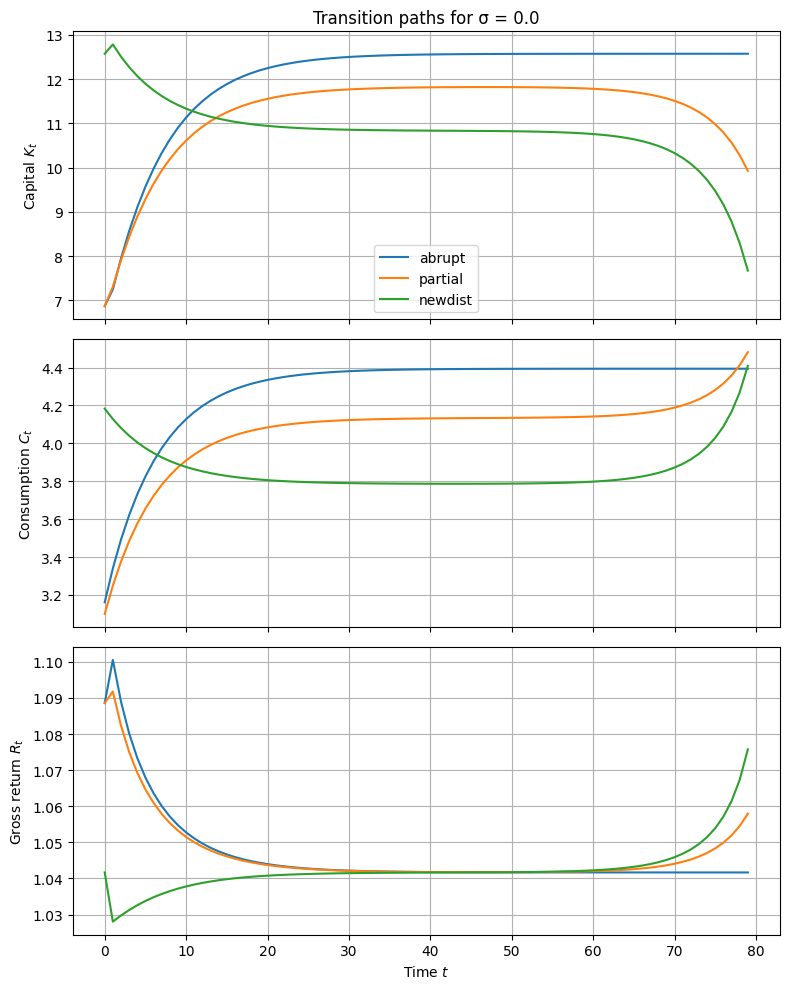

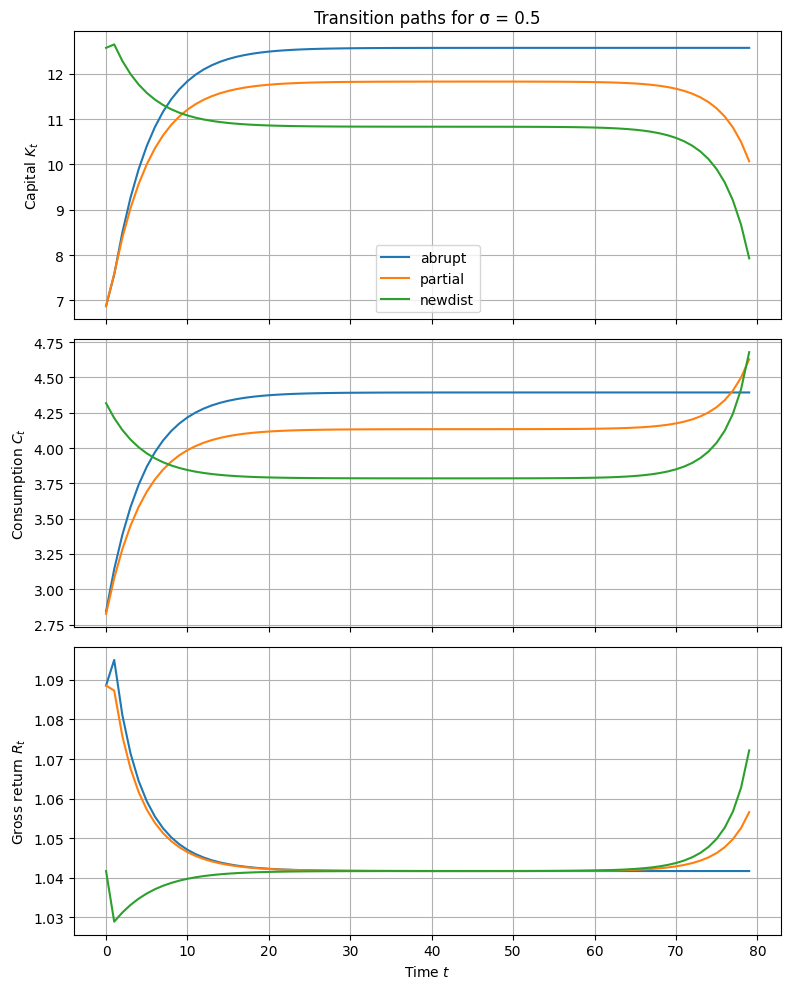

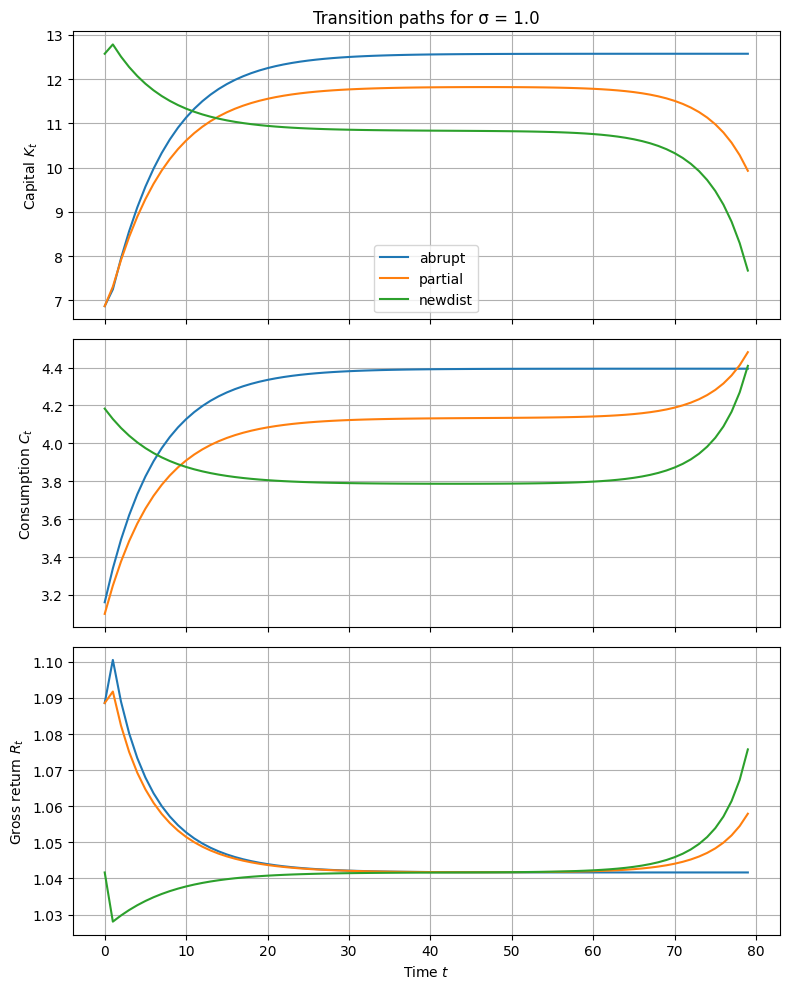

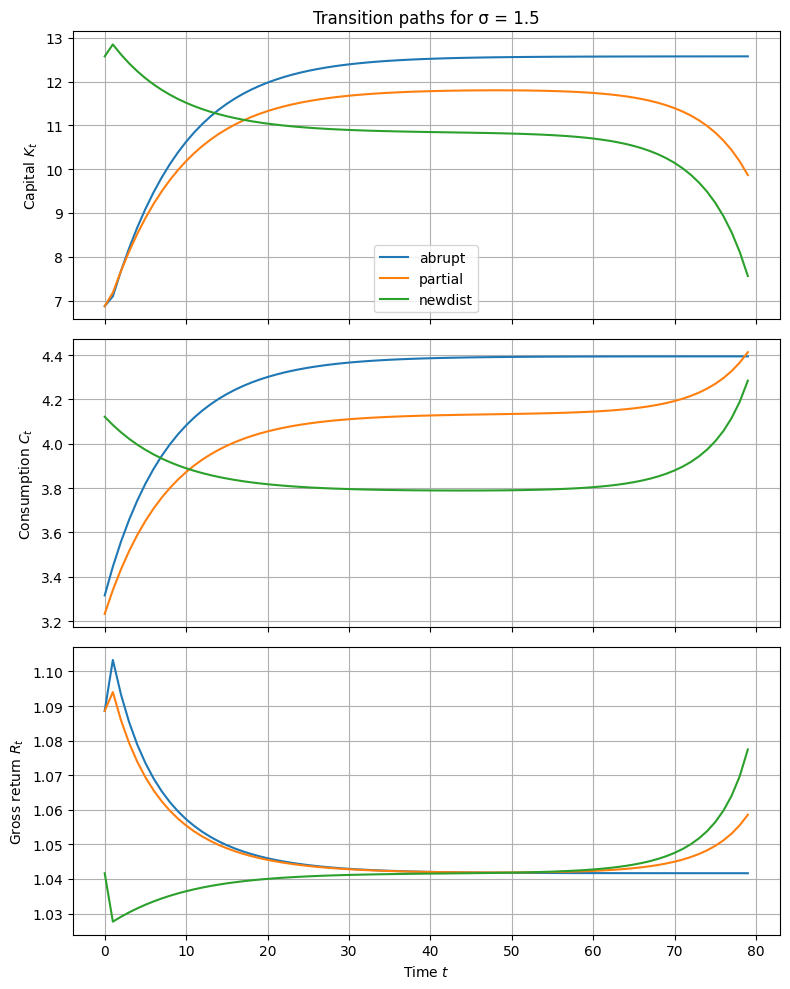

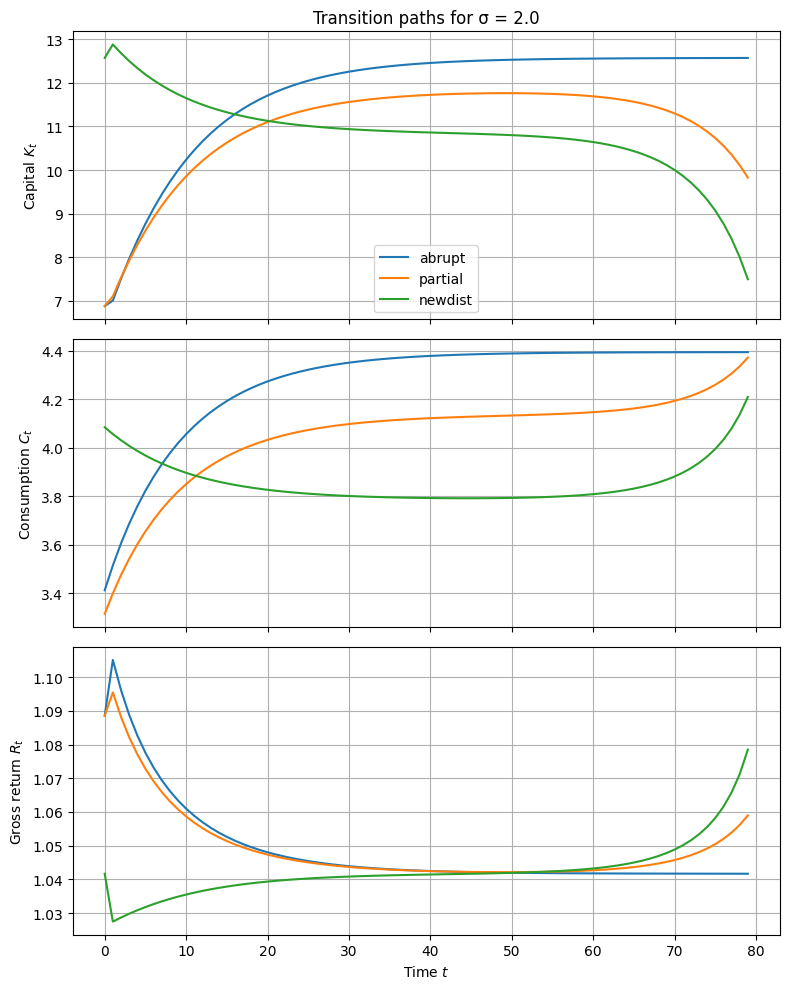

In [17]:
# 15b) Plot transition paths by sigma (holding preferences fixed)

import matplotlib.pyplot as plt

vars_to_plot = ["K_t", "C_t", "R_t"]
var_labels = {
    "K_t": "Capital $K_t$",
    "C_t": "Consumption $C_t$",
    "R_t": "Gross return $R_t$",
}

# new dataframe to collect all results
rows_all = []

# recompute and store paths for each sigma and each scenario
for sigma in sigma_vals:
    for scen_name, (A_path, K_start, K_end) in {
        "abrupt": (A_abrupt, distorted["K"], clean["K"]),
        "partial": (A_partial, distorted["K"], partial["K"]),
        "newdist": (A_newdist, clean["K"], newdist["K"]),
    }.items():
        sim = simulate_transition(cal, A_path, K_start, K_end, sigma=sigma, T=T)
        for t in range(T):
            rows_all.append({
                "sigma": sigma,
                "scenario": scen_name,
                "t": t,
                "K_t": sim["K"][t],
                "C_t": sim["C"][t],
                "R_t": sim["R"][t],
            })

paths_all_df = pd.DataFrame(rows_all)

for sigma in sigma_vals:
    df_sigma = paths_all_df[paths_all_df["sigma"] == sigma]
    
    fig, axes = plt.subplots(3, 1, figsize=(8, 10), sharex=True)
    
    for i, var in enumerate(vars_to_plot):
        ax = axes[i]
        for scen in ["abrupt", "partial", "newdist"]:
            df_plot = df_sigma[df_sigma["scenario"] == scen]
            ax.plot(df_plot["t"], df_plot[var], label=scen)
        ax.set_ylabel(var_labels[var])
        ax.grid(True)
    
    axes[0].set_title(f"Transition paths for σ = {sigma}")
    axes[-1].set_xlabel("Time $t$")
    axes[0].legend()
    plt.tight_layout()
    plt.show()


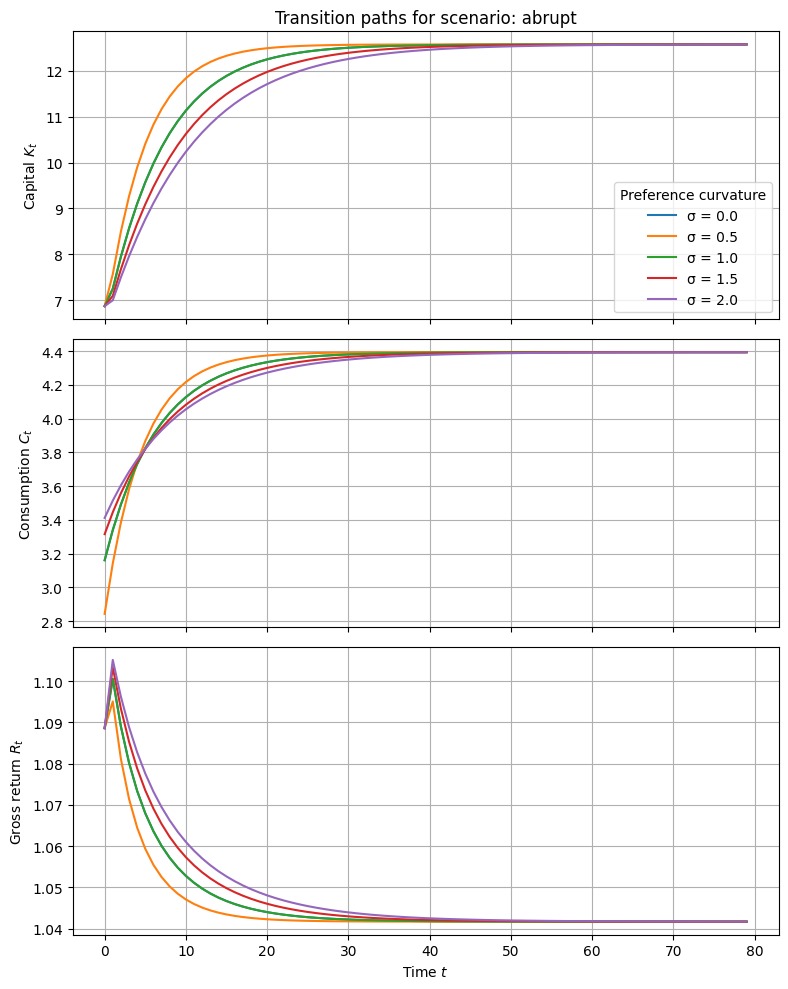

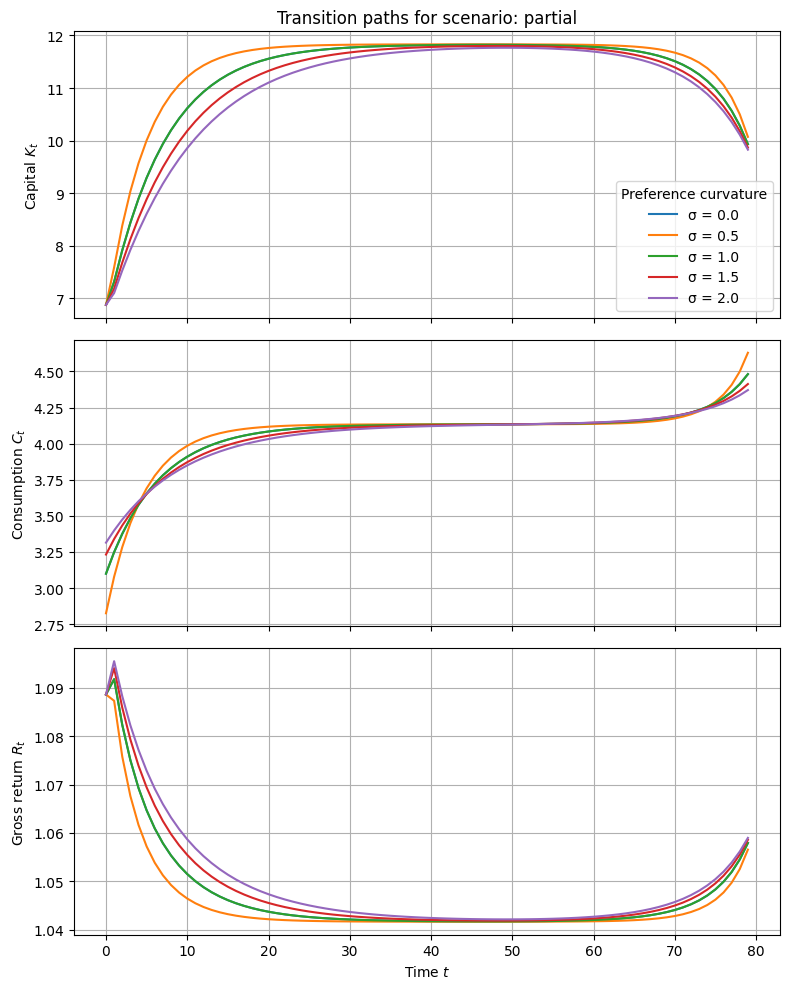

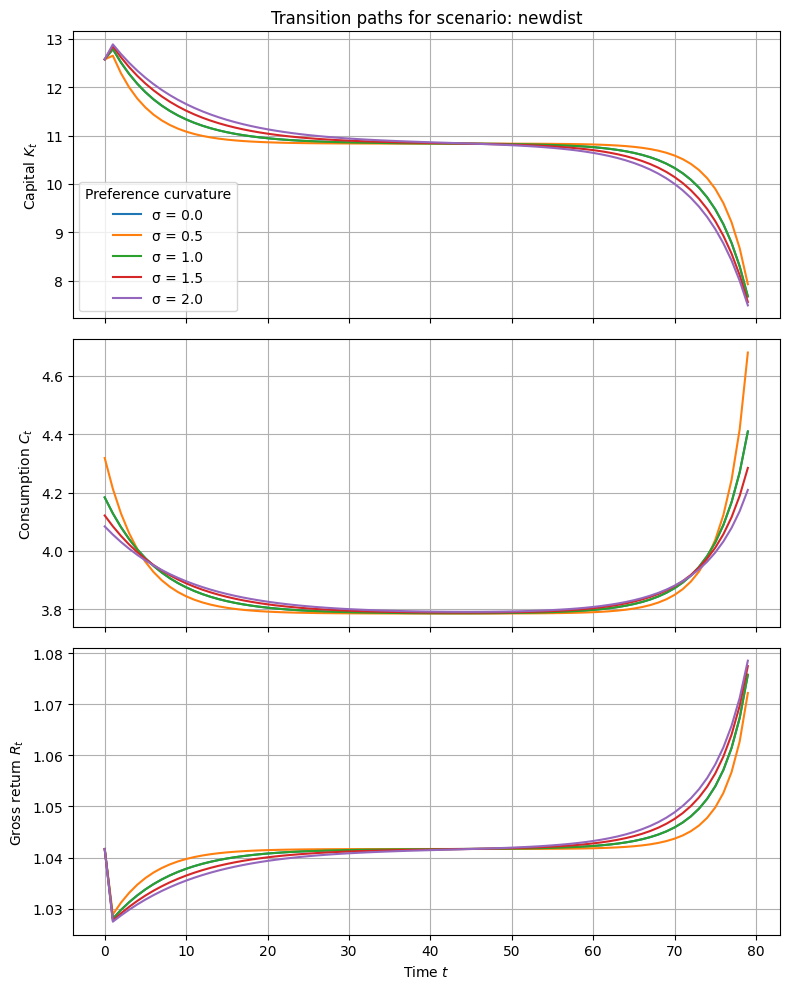

In [ ]:
# --- 15c) Plot transition paths grouped by scenario, showing multiple preferences

import matplotlib.pyplot as plt

vars_to_plot = ["K_t", "C_t", "R_t"]
var_labels = {
    "K_t": "Capital $K_t$",
    "C_t": "Consumption $C_t$",
    "R_t": "Gross return $R_t$",
}

for scen in ["abrupt", "partial", "newdist"]:
    df_scen = paths_all_df[paths_all_df["scenario"] == scen]
    
    fig, axes = plt.subplots(3, 1, figsize=(8, 10), sharex=True)
    
    for i, var in enumerate(vars_to_plot):
        ax = axes[i]
        for sigma in sigma_vals:
            df_plot = df_scen[df_scen["sigma"] == sigma]
            ax.plot(df_plot["t"], df_plot[var], label=f"σ = {sigma}")
        ax.set_ylabel(var_labels[var])
        ax.grid(True)
    
    axes[0].set_title(f"Transition paths for scenario - {scen}")
    axes[-1].set_xlabel("Time $t$")
    axes[0].legend(title="Preference curvature")
    plt.tight_layout()
    plt.show()


In [19]:
# Transition wrapper with explicit entry/exit-like A_t

import numpy as np
import pandas as pd

def rr_static_from_spec(cal: Calib, hs: np.ndarray, spec: dict):
    st_tmp = State(r=st.r, i=st.i, s=st.s, z=st.z, smatrix=st.smatrix.copy())
    if spec["type"] == "none":
        set_joint_density(cal, st_tmp, hs, mode="benchmark", sub=0.0, nosub=0.0)
        set_tax_matrices(cal, st_tmp, tau=0.0, taus=0.0, base="output")
    elif spec["type"] == "corr":
        sub = spec.get("sub", 0.5)
        tau = spec.get("tau", 0.3)
        set_joint_density(cal, st_tmp, hs, mode="corr_low_sub", sub=sub, nosub=0.0)
        set_tax_matrices(cal, st_tmp, tau=tau, taus=0.0, base="output")
    elif spec["type"] == "iid":
        sub = spec.get("sub", 0.5)
        tau = spec.get("tau", 0.3)
        set_joint_density(cal, st_tmp, hs, mode="iid", sub=sub, nosub=0.0)
        set_tax_matrices(cal, st_tmp, tau=tau, taus=0.0, base="output")
    else:
        raise ValueError(f"unknown spec type {spec['type']}")
    # solve for wage, get aggregates
    w = solve_wage_by_bisection(cal, st_tmp)
    st_tmp.w = w
    aggs = invariant_and_aggregates(cal, st_tmp)
    return {
        "A": aggs["A"],
        "K": aggs["K"],
        "Y": aggs["Y"],
        "w": aggs["w"],
        "aggs": aggs,
    }

def build_A_path_with_entry_exit(A_dist, A_clean, T, lambda_entry=0.15):
    """
    Simple 'explicit' entry/exit dynamics:
      m_t = 1 - exp(-lambda * t)
      A_t = A_dist + m_t * (A_clean - A_dist)
    Interpretation: each period, a fraction of low-s firms is replaced by high-s firms,
    so the efficient share rises smoothly.
    """
    t = np.arange(T)
    m_t = 1.0 - np.exp(-lambda_entry * t)   # increasing from 0 to 1
    A_t = A_dist + m_t * (A_clean - A_dist)
    return A_t

def simulate_transition(cal: Calib, A_path, K0, K_terminal, sigma=1.0, T=None, max_iter=60, tol=1e-6):
    """
    Same shooting transition as before.
    """
    alpha, beta, delta = cal.alpha, cal.beta, cal.delta
    A_path = np.array(A_path, dtype=float)
    if T is None:
        T = len(A_path)
    else:
        A_path = A_path[:T]

    y0 = A_path[0] * (K0 ** alpha)
    c0_lo = 1e-8
    c0_hi = y0

    def forward(c0):
        k = np.zeros(T+1)
        c = np.zeros(T)
        r = np.zeros(T)
        k[0] = K0
        c[0] = c0
        for t in range(T):
            A = A_path[t]
            y = A * (k[t] ** alpha)
            r[t] = alpha * A * (k[t] ** (alpha - 1.0)) + (1.0 - delta)
            k[t+1] = y + (1.0 - delta) * k[t] - c[t]
            if k[t+1] <= 0:
                return k, c, r
            if t < T-1:
                A_next = A_path[t+1]
                R_next = alpha * A_next * (k[t+1] ** (alpha - 1.0)) + (1.0 - delta)
                if sigma == 1.0:
                    c[t+1] = c[t] * (beta * R_next)
                else:
                    c[t+1] = c[t] * (beta * R_next) ** (1.0 / sigma)
        return k, c, r

    # bisection on c0
    k_lo, _, _ = forward(c0_lo)
    k_hi, _, _ = forward(c0_hi*0.999)
    for _ in range(max_iter):
        c0_mid = 0.5*(c0_lo + c0_hi)
        k_mid, c_mid, r_mid = forward(c0_mid)
        gap = k_mid[-1] - K_terminal
        if abs(gap) < tol:
            return dict(K=k_mid, C=c_mid, R=r_mid, c0=c0_mid)
        if gap > 0:
            c0_lo = c0_mid
        else:
            c0_hi = c0_mid
    return dict(K=k_mid, C=c_mid, R=r_mid, c0=c0_mid)

def crra_utility(c, sigma):
    c = np.maximum(c, 1e-12)
    if sigma == 1.0:
        return np.log(c)
    else:
        return c**(1.0 - sigma) / (1.0 - sigma)

def welfare_from_path(cal: Calib, C_path, c_ss, sigma):
    beta = cal.beta
    T = len(C_path)
    disc = beta ** np.arange(T)
    flow = crra_utility(np.array(C_path), sigma)
    W = np.sum(disc * flow)
    W += (beta ** T) * crra_utility(c_ss, sigma) / (1.0 - beta)
    return W

# base economies from RR
spec_distorted = {"type": "corr", "tau": 0.3, "sub": 0.5}
spec_clean     = {"type": "none"}

distorted = rr_static_from_spec(cal, hs, spec_distorted)
clean     = rr_static_from_spec(cal, hs, spec_clean)

T = 80
lambda_fast  = 0.25   # fast reallocation
lambda_slow  = 0.05   # slow reallocation

# scenario 1: abrupt in RR but gradual in micro (fast reallocation)
A_fast = build_A_path_with_entry_exit(distorted["A"], clean["A"], T, lambda_entry=lambda_fast)

# scenario 2: same but slow
A_slow = build_A_path_with_entry_exit(distorted["A"], clean["A"], T, lambda_entry=lambda_slow)

# scenario 3: move to a partially improved RR economy
spec_partial = {"type": "corr", "tau": 0.15, "sub": 0.5}
partial = rr_static_from_spec(cal, hs, spec_partial)
A_partial = build_A_path_with_entry_exit(distorted["A"], partial["A"], T, lambda_entry=lambda_fast)

sigma_vals = [0.5, 1.0, 1.5, 2.0]
records = []
rows_all = []

for sigma in sigma_vals:
    # fast to clean
    sim_fast = simulate_transition(cal, A_fast, distorted["K"], clean["K"], sigma=sigma, T=T)
    c_ss_clean = clean["Y"] - cal.delta * clean["K"]
    W_fast = welfare_from_path(cal, sim_fast["C"], c_ss_clean, sigma)

    # slow to clean
    sim_slow = simulate_transition(cal, A_slow, distorted["K"], clean["K"], sigma=sigma, T=T)
    W_slow = welfare_from_path(cal, sim_slow["C"], c_ss_clean, sigma)

    # partial
    c_ss_partial = partial["Y"] - cal.delta * partial["K"]
    sim_partial = simulate_transition(cal, A_partial, distorted["K"], partial["K"], sigma=sigma, T=T)
    W_partial = welfare_from_path(cal, sim_partial["C"], c_ss_partial, sigma)

    records.append({
        "sigma": sigma,
        "W_fast": W_fast,
        "W_slow": W_slow,
        "W_partial": W_partial,
    })

    # store paths for plotting
    for t in range(T):
        rows_all.append({
            "sigma": sigma,
            "scenario": "fast_clean",
            "t": t,
            "K_t": sim_fast["K"][t],
            "C_t": sim_fast["C"][t],
            "R_t": sim_fast["R"][t],
        })
        rows_all.append({
            "sigma": sigma,
            "scenario": "slow_clean",
            "t": t,
            "K_t": sim_slow["K"][t],
            "C_t": sim_slow["C"][t],
            "R_t": sim_slow["R"][t],
        })
        rows_all.append({
            "sigma": sigma,
            "scenario": "partial",
            "t": t,
            "K_t": sim_partial["K"][t],
            "C_t": sim_partial["C"][t],
            "R_t": sim_partial["R"][t],
        })

welfare_df2 = pd.DataFrame.from_records(records)
display(welfare_df2)
to_latex_table(welfare_df2, "Explicit Entry/Exit Welfare Comparison Under Various Preferences",
               "tab:EEwelfare_df", "EEwelfare.tex", float_format="%.2f", index=True)
paths_all_df = pd.DataFrame(rows_all)
display(paths_all_df.head())
to_latex_table(paths_all_df, "Sample of the Transition Paths",
               "tab:sample_path", "sample_path.tex", float_format="%.2f", index=True)

,sigma,W_fast,W_slow,W_partial
0,0.5,100.556842,98.556527,98.200669
1,1.0,34.856554,33.853726,33.692574
2,1.5,-24.931718,-25.437630,-25.509701
3,2.0,-6.229159,-6.485313,-6.517172


,sigma,scenario,t,K_t,C_t,R_t
0,0.5,fast_clean,0,6.872208,2.824672,1.088598
1,0.5,slow_clean,0,6.872208,2.808219,1.088598
2,0.5,partial,0,6.872208,2.814426,1.088598
3,0.5,fast_clean,1,7.587075,3.041857,1.080971
4,0.5,slow_clean,1,7.603528,3.005714,1.077673


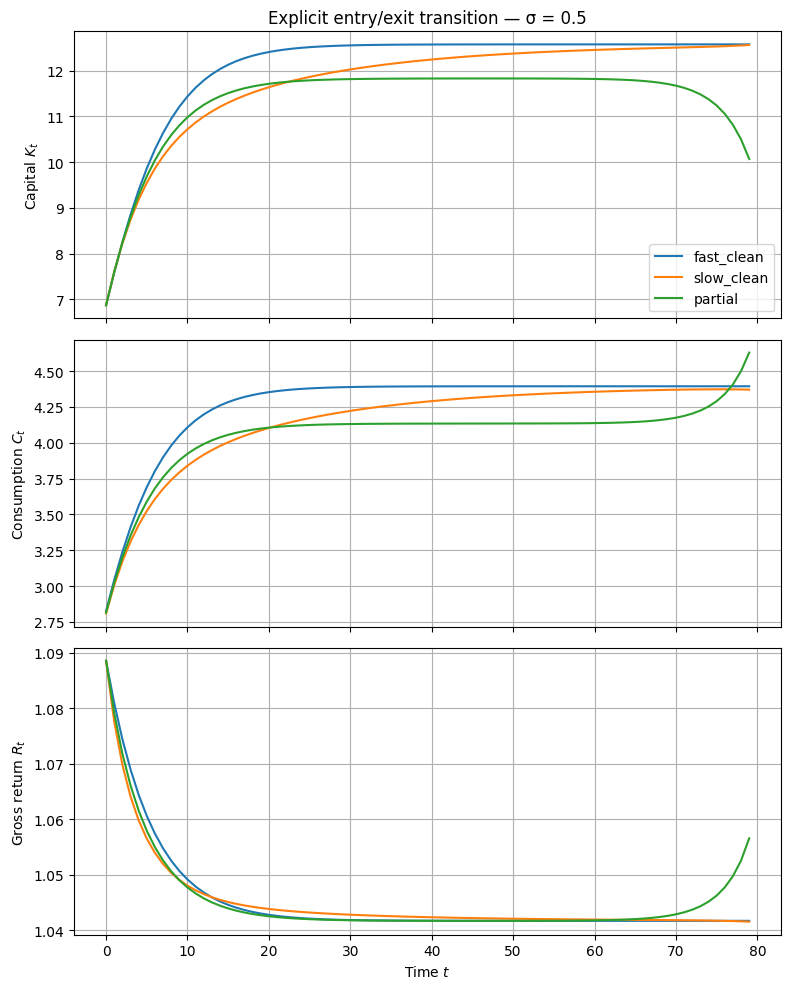

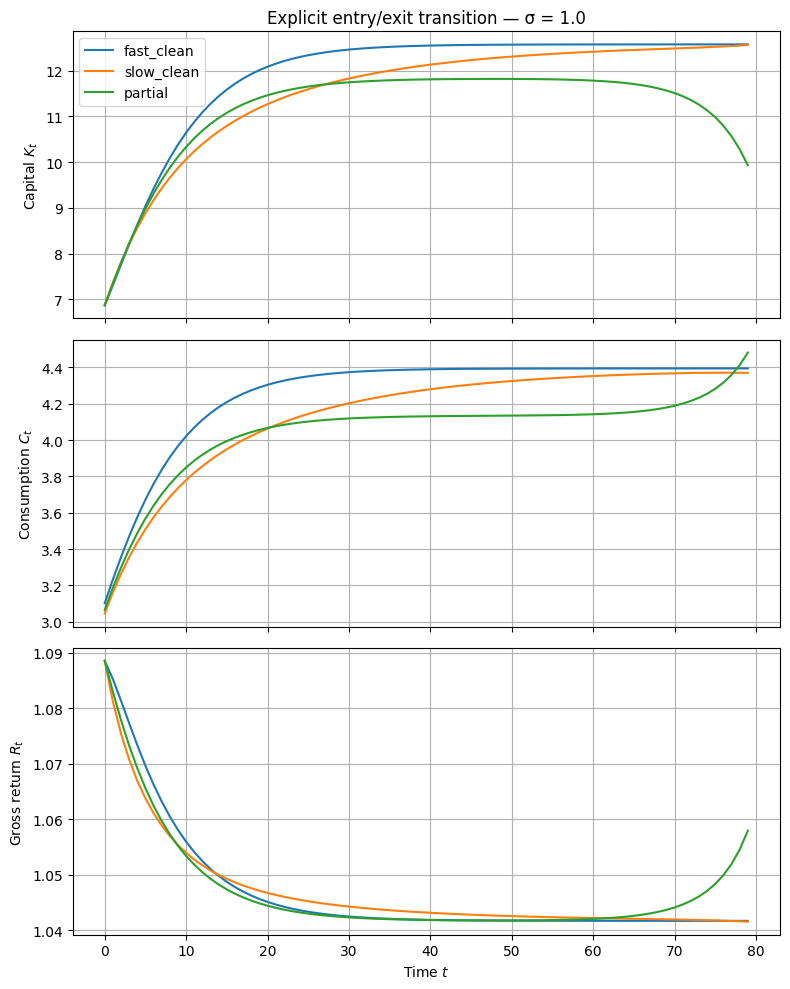

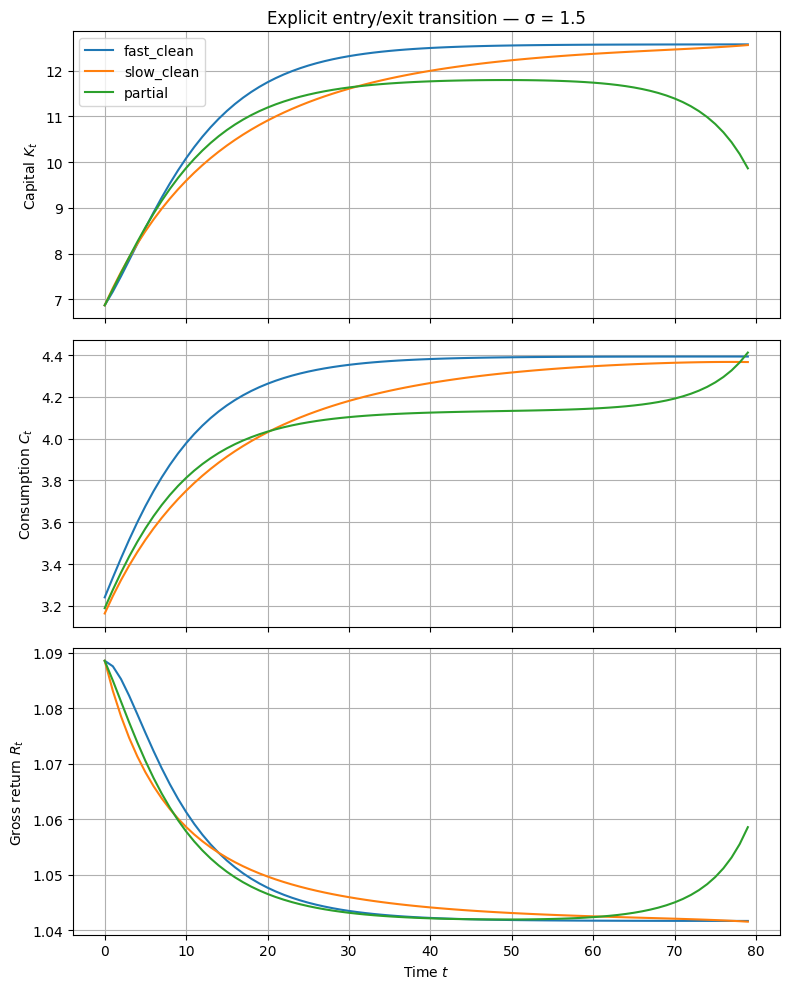

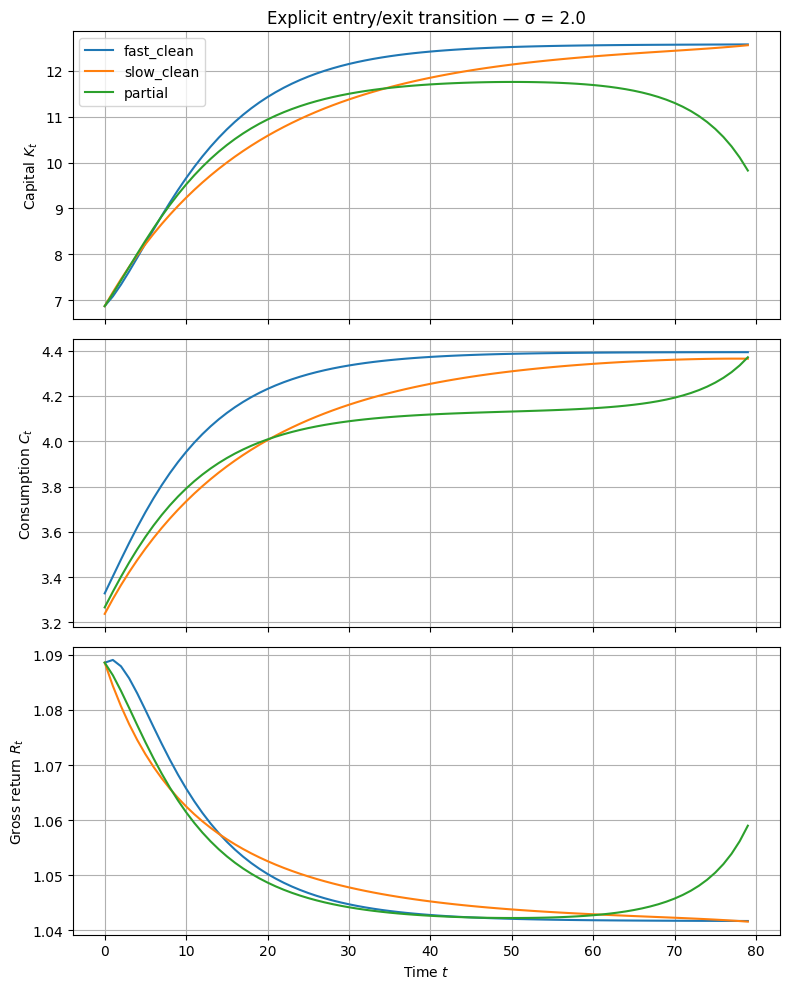

In [ ]:
# plots for explicit entry/exit transition

import matplotlib.pyplot as plt

vars_to_plot = ["K_t", "C_t", "R_t"]
var_labels = {
    "K_t": "Capital $K_t$",
    "C_t": "Consumption $C_t$",
    "R_t": "Gross return $R_t$",
}

for sigma in sigma_vals:
    df_sigma = paths_all_df[paths_all_df["sigma"] == sigma]
    
    fig, axes = plt.subplots(3, 1, figsize=(8, 10), sharex=True)
    
    for i, var in enumerate(vars_to_plot):
        ax = axes[i]
        for scen in ["fast_clean", "slow_clean", "partial"]:
            df_plot = df_sigma[df_sigma["scenario"] == scen]
            ax.plot(df_plot["t"], df_plot[var], label=scen)
        ax.set_ylabel(var_labels[var])
        ax.grid(True)
    
    axes[0].set_title(f"Explicit entry/exit transition - σ = {sigma}")
    axes[-1].set_xlabel("Time $t$")
    axes[0].legend()
    plt.tight_layout()
    plt.show()


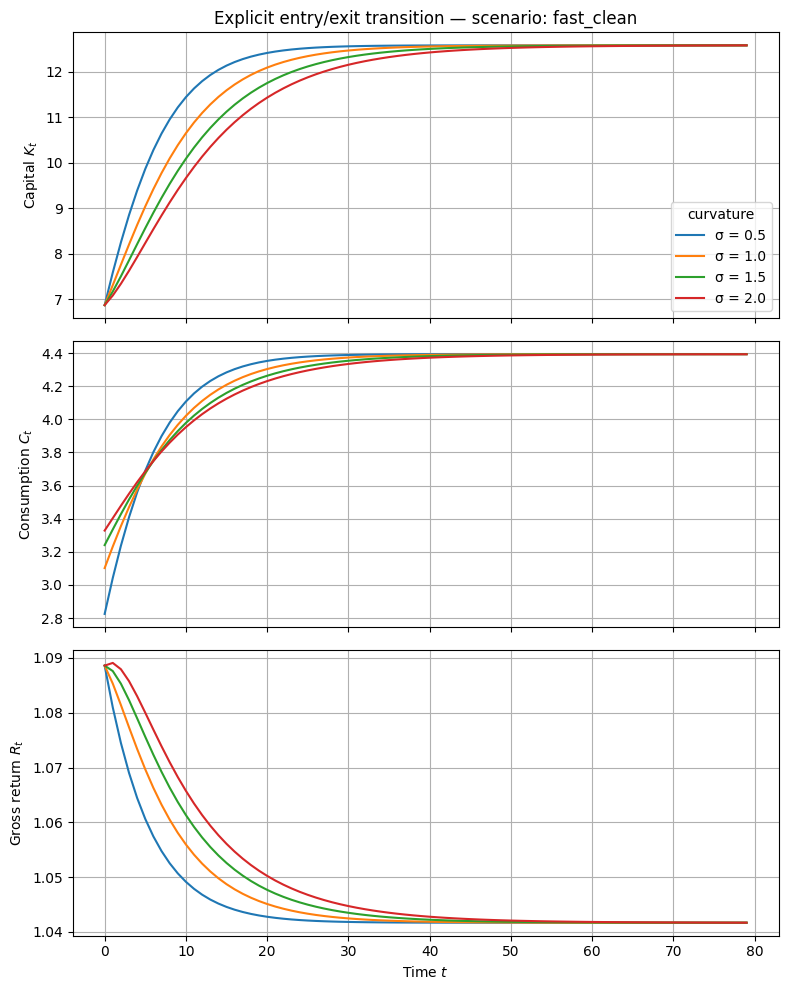

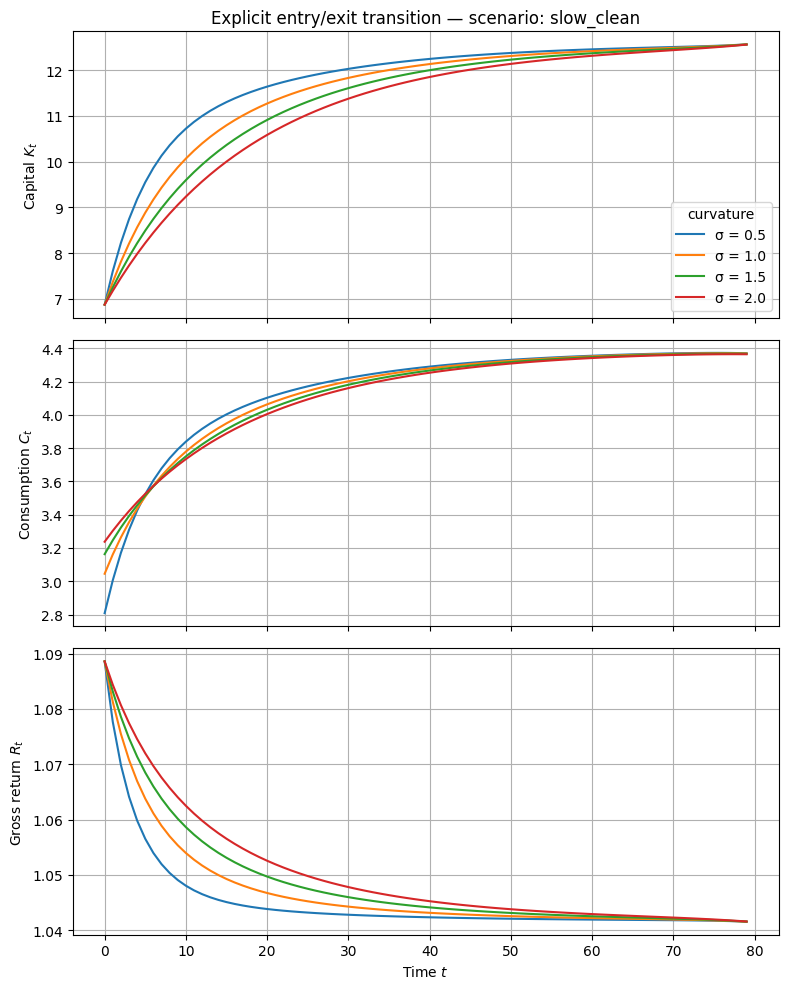

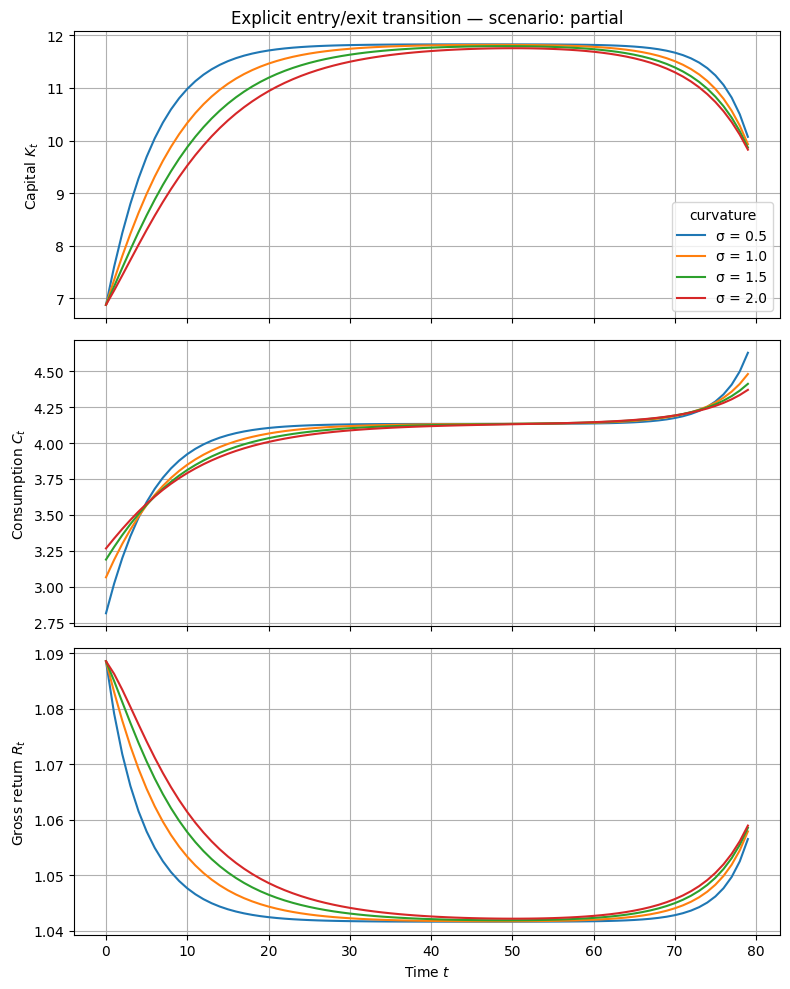

In [21]:
# plots for explicit entry/exit transition (compare curvature)

for scen in ["fast_clean", "slow_clean", "partial"]:
    df_scen = paths_all_df[paths_all_df["scenario"] == scen]
    
    fig, axes = plt.subplots(3, 1, figsize=(8, 10), sharex=True)
    
    for i, var in enumerate(vars_to_plot):
        ax = axes[i]
        for sigma in sigma_vals:
            df_plot = df_scen[df_scen["sigma"] == sigma]
            ax.plot(df_plot["t"], df_plot[var], label=f"σ = {sigma}")
        ax.set_ylabel(var_labels[var])
        ax.grid(True)
    
    axes[0].set_title(f"Explicit entry/exit transition — scenario: {scen}")
    axes[-1].set_xlabel("Time $t$")
    axes[0].legend(title="curvature")
    plt.tight_layout()
    plt.show()


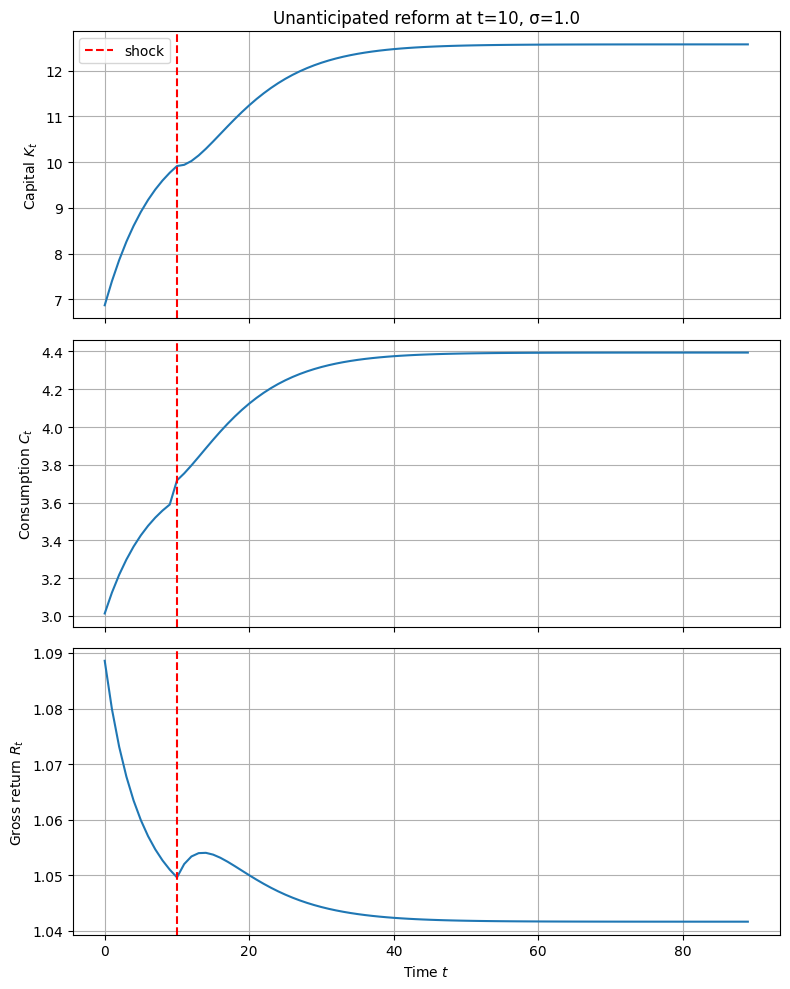

In [22]:
# Unanticipated shock extension
# We assume we already have:
# - distorted (RR distorted static)
# - clean (RR clean static)
# - build_A_path_with_entry_exit(...)
# - simulate_transition(...)
# - cal, hs, etc.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def simulate_unanticipated_shock(
    cal: Calib,
    A_pre: np.ndarray,
    A_post: np.ndarray,
    K0: float,
    K_post_ss: float,
    sigma: float,
    t_shock: int,
):
    """
    1) run economy along A_pre for t_shock periods, taking c each period from
       the 'pre' perceived path (we do this by just simulating a transition to the PRE steady state)
    2) at t = t_shock, switch to A_post and re-solve forward from K_{t_shock}
    We return concatenated paths.
    """
    T_pre = len(A_pre)
    assert t_shock < T_pre, "shock time must be within the pre path horizon"

    # First: pretend the agent thinks the distorted situation persists
    # -> just simulate toward the distorted steady state using the pre path
    # target K is the steady K consistent with A_pre's final level
    K_pre_ss = K0  # we'll overwrite right below

    # final A in pre-path
    A_pre_final = A_pre[-1]
    # RR steady state for distorted was 'distorted', so we can just use that K
    # (you can refine this if A_pre is not exactly flat)
    K_pre_ss = distorted["K"]

    sim_pre = simulate_transition(
        cal,
        A_pre,
        K0,
        K_pre_ss,
        sigma=sigma,
        T=T_pre
    )

    # capital at the moment of the surprise
    K_at_shock = sim_pre["K"][t_shock]

    # Now: from shock onward, the world is A_post and the terminal K is K_post_ss
    T_post = len(A_post)
    sim_post = simulate_transition(
        cal,
        A_post,
        K_at_shock,
        K_post_ss,
        sigma=sigma,
        T=T_post
    )

    # stitch paths
    K_full = np.concatenate([sim_pre["K"][:t_shock+1], sim_post["K"][1:]])
    C_full = np.concatenate([sim_pre["C"][:t_shock],    sim_post["C"]])
    R_full = np.concatenate([sim_pre["R"][:t_shock],    sim_post["R"]])

    min_len = min(len(K_full), len(C_full), len(R_full))
    K_full = K_full[:min_len]
    C_full = C_full[:min_len]
    R_full = R_full[:min_len]

    return {
        "K": K_full,
        "C": C_full,
        "R": R_full,
        "t_shock": t_shock,
    }


T = 80
# pre: distorted stays distorted (flat A)
A_dist_flat = np.full(T, distorted["A"])
# post: gradual reform to clean, using our entry/exit smooth path
A_clean_smooth = build_A_path_with_entry_exit(distorted["A"], clean["A"], T, lambda_entry=0.2)

t_shock = 10   # surprise at period 10
sigma_demo = 1.0

sim_shock = simulate_unanticipated_shock(
    cal,
    A_pre=A_dist_flat,
    A_post=A_clean_smooth,
    K0=distorted["K"],
    K_post_ss=clean["K"],
    sigma=sigma_demo,
    t_shock=t_shock
)

# plot the unanticipated-shock transition

fig, axes = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

time = np.arange(len(sim_shock["K"]))

axes[0].plot(time, sim_shock["K"])
axes[1].plot(time, sim_shock["C"])
axes[2].plot(time, sim_shock["R"])

for ax in axes:
    ax.axvline(t_shock, color="red", linestyle="--", label="shock")
    ax.grid(True)

axes[0].set_ylabel("Capital $K_t$")
axes[1].set_ylabel("Consumption $C_t$")
axes[2].set_ylabel("Gross return $R_t$")
axes[-1].set_xlabel("Time $t$")
axes[0].set_title(f"Unanticipated reform at t={t_shock}, σ={sigma_demo}")
axes[0].legend()

plt.tight_layout()
plt.show()


In [ ]:
# Welfare table: Unanticipated vs Foreseen
import numpy as np
import pandas as pd


beta = cal.beta
def welfare_from_path(C, C_ss, beta, sigma, eps=1e-12):
    C = np.maximum(np.asarray(C, float), eps)
    C_ss = max(float(C_ss), eps)
    Tloc = len(C)
    if sigma != 1.0:
        W = np.sum([(beta**t) * (C[t]**(1 - sigma)) / (1 - sigma) for t in range(Tloc)])
        W += (beta**Tloc) * (C_ss**(1 - sigma)) / ((1 - sigma) * (1 - beta))
    else:
        W = np.sum([(beta**t) * np.log(C[t]) for t in range(Tloc)])
        W += (beta**Tloc) * np.log(C_ss) / (1 - beta)
    return float(W)

def ce_relative(C_ref, C_ref_ss, C_alt, C_alt_ss, beta, sigma, eps=1e-12):
    C_ref = np.maximum(np.asarray(C_ref, float), eps)
    C_alt = np.maximum(np.asarray(C_alt, float), eps)
    C_ref_ss = max(float(C_ref_ss), eps)
    C_alt_ss = max(float(C_alt_ss), eps)
    Tloc = len(C_ref)
    if sigma != 1.0:
        num = np.sum([beta**t * (C_ref[t]**(1 - sigma)) for t in range(Tloc)]) \
              + (beta**Tloc) * (C_ref_ss**(1 - sigma)) / (1 - beta)
        den = np.sum([beta**t * (C_alt[t]**(1 - sigma)) for t in range(Tloc)]) \
              + (beta**Tloc) * (C_alt_ss**(1 - sigma)) / (1 - beta)
        lam = (num / den) ** (1 / (1 - sigma))
    else:
        num = np.sum([beta**t * np.log(C_ref[t]) for t in range(Tloc)]) \
              + (beta**Tloc) * np.log(C_ref_ss) / (1 - beta)
        den = np.sum([beta**t * np.log(C_alt[t]) for t in range(Tloc)]) \
              + (beta**Tloc) * np.log(C_alt_ss) / (1 - beta)
        lam = np.exp((1 - beta) * (num - den))
    return float(lam)

def time_to_fraction_ss(C, C_ss, frac=0.90):
    target = frac * float(C_ss)
    for t, c in enumerate(C):
        if c >= target:
            return t
    return np.nan

def peak_pct_dev_from_ss(C, C_ss):
    C = np.asarray(C, float)
    if C_ss <= 0:
        return np.nan
    rel = (C - C_ss) / C_ss * 100.0
    return float(np.min(rel))

welfare_rows = []
for sigma in sigma_vals:
    sim_unant = simulate_unanticipated_shock(
        cal,
        A_pre=A_dist_flat,
        A_post=A_clean_smooth,
        K0=distorted["K"],
        K_post_ss=clean["K"],
        sigma=sigma,
        t_shock=t_shock,
    )
    # Simulate foreseen (perfect foresight)
    sim_fore = simulate_transition(
        cal,
        A_clean_smooth,
        distorted["K"],
        clean["K"],
        sigma=sigma,
        T=T
    )

    # Align horizons
    Tlen = min(len(sim_unant["C"]), len(sim_fore["C"]))
    C_un = sim_unant["C"][:Tlen]
    C_fo = sim_fore["C"][:Tlen]
    C_un_ss, C_fo_ss = float(C_un[-1]), float(C_fo[-1])

    # Compute welfare
    W_un = welfare_from_path(C_un, C_un_ss, beta, sigma)
    W_fo = welfare_from_path(C_fo, C_fo_ss, beta, sigma)
    lam = ce_relative(C_ref=C_fo, C_ref_ss=C_fo_ss, C_alt=C_un, C_alt_ss=C_un_ss,
                      beta=beta, sigma=sigma)
    CE_loss_pct = (lam - 1.0) * 100.0

    # Diagnostics (kind of optional)
    t90_un = time_to_fraction_ss(C_un, C_un_ss, frac=0.90)
    t90_fo = time_to_fraction_ss(C_fo, C_fo_ss, frac=0.90)
    peak_un = peak_pct_dev_from_ss(C_un, C_un_ss)
    peak_fo = peak_pct_dev_from_ss(C_fo, C_fo_ss)

    welfare_rows.append({
        "sigma": sigma,
        "CE_loss_unanticipated_vs_foreseen_%": CE_loss_pct,
        "W_unanticipated": W_un,
        "W_foreseen": W_fo,
        "time_to_90pct_ss_unanticipated": t90_un,
        "time_to_90pct_ss_foreseen": t90_fo,
        "peak_pct_dev_unanticipated": peak_un,
        "peak_pct_dev_foreseen": peak_fo,
    })

welfare_df3 = pd.DataFrame(welfare_rows).sort_values(by="sigma").reset_index(drop=True)
display(welfare_df2)

to_latex_table(welfare_df3,"Welfare comparison (unanticipated vs foreseen) by $\\sigma$","tab:welfare_unanticipated_vs_foreseen", 
               "welfare_unanticipated_vs_foreseen.tex",
        float_format="%.3f",
        index=False)


,sigma,CE_loss_unanticipated_vs_foreseen_%,W_unanticipated,W_foreseen,time_to_90pct_ss_unanticipated,time_to_90pct_ss_foreseen,peak_pct_dev_unanticipated,peak_pct_dev_foreseen
0,0.5,3.725588,98.549445,100.368431,15,9,-36.282682,-35.777152
1,1.0,3.788315,33.831559,34.761140,16,10,-31.434243,-29.612571
2,1.5,3.864684,-25.458419,-24.980290,16,11,-29.103247,-26.519069
3,2.0,3.945527,-6.500698,-6.253947,17,11,-27.652660,-24.548161


In [ ]:
# Build shock scenarios across sigma values

sigma_vals = [0.5, 1.0, 1.5, 2.0]
t_shock = 10
T = 80

# baseline paths
A_dist_flat = np.full(T, distorted["A"])
A_clean_smooth = build_A_path_with_entry_exit(distorted["A"], clean["A"], T, lambda_entry=0.2)

rows_all = []

for sigma in sigma_vals:
    sim_unanticipated = simulate_unanticipated_shock(
        cal,
        A_pre=A_dist_flat,
        A_post=A_clean_smooth,
        K0=distorted["K"],
        K_post_ss=clean["K"],
        sigma=sigma,
        t_shock=t_shock,
    )
    for t in range(len(sim_unanticipated["C"])):
        rows_all.append({
            "sigma": sigma,
            "scenario": "unanticipated",
            "t": t,
            "K_t": sim_unanticipated["K"][t],
            "C_t": sim_unanticipated["C"][t],
            "R_t": sim_unanticipated["R"][t],
        })

# also add a perfect-foresight baseline for comparison
for sigma in sigma_vals:
    A_path = A_clean_smooth
    sim_foreseen = simulate_transition(cal, A_path, distorted["K"], clean["K"], sigma=sigma, T=T)
    for t in range(T):
        rows_all.append({
            "sigma": sigma,
            "scenario": "foreseen",
            "t": t,
            "K_t": sim_foreseen["K"][t],
            "C_t": sim_foreseen["C"][t],
            "R_t": sim_foreseen["R"][t],
        })

paths_all_df2 = pd.DataFrame(rows_all)
display(paths_all_df2.head())
to_latex_table(paths_all_df2, "A Sample of the Transition Paths with Unanticipated Shocks",
               "tab:sample_path_unant", "sample_path_unant.tex", float_format="%.2f", index=True)

,sigma,scenario,t,K_t,C_t,R_t
0,0.5,unanticipated,0,6.872208,2.799751,1.088598
1,0.5,unanticipated,1,7.611996,2.991162,1.076686
2,0.5,unanticipated,2,8.221381,3.145912,1.068272
3,0.5,unanticipated,3,8.720128,3.270816,1.062144
4,0.5,unanticipated,4,9.126467,3.371512,1.057580


,sigma,reform,information,t,K_t,C_t,R_t
0,0.5,abrupt,foreseen,0,6.872208,2.956180,1.107605
1,0.5,abrupt,foreseen,1,7.916593,3.234007,1.089516
2,0.5,abrupt,foreseen,2,8.785705,3.459194,1.077323
3,0.5,abrupt,foreseen,3,9.501972,3.641273,1.068730
4,0.5,abrupt,foreseen,4,10.088398,3.788248,1.062481


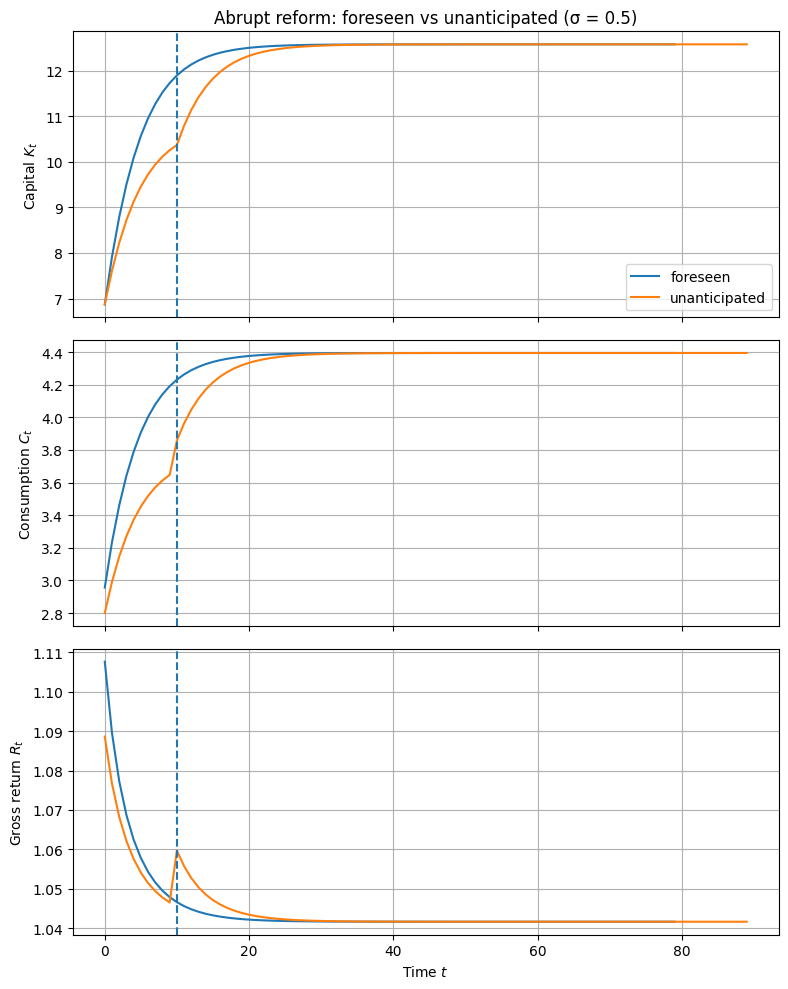

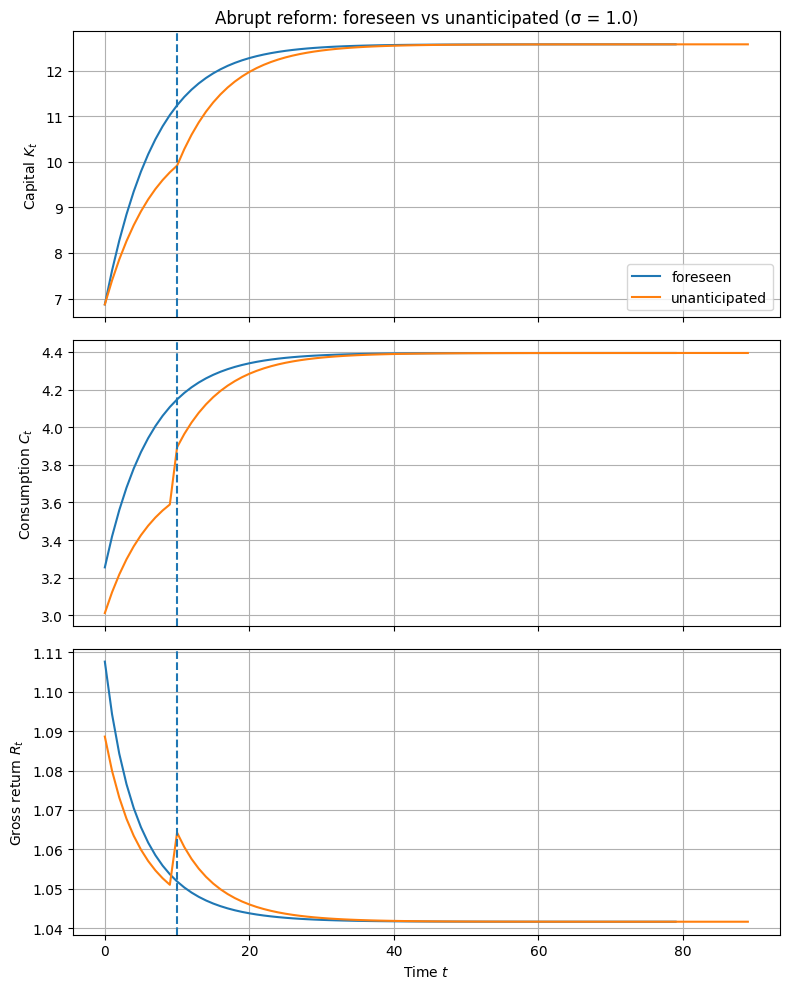

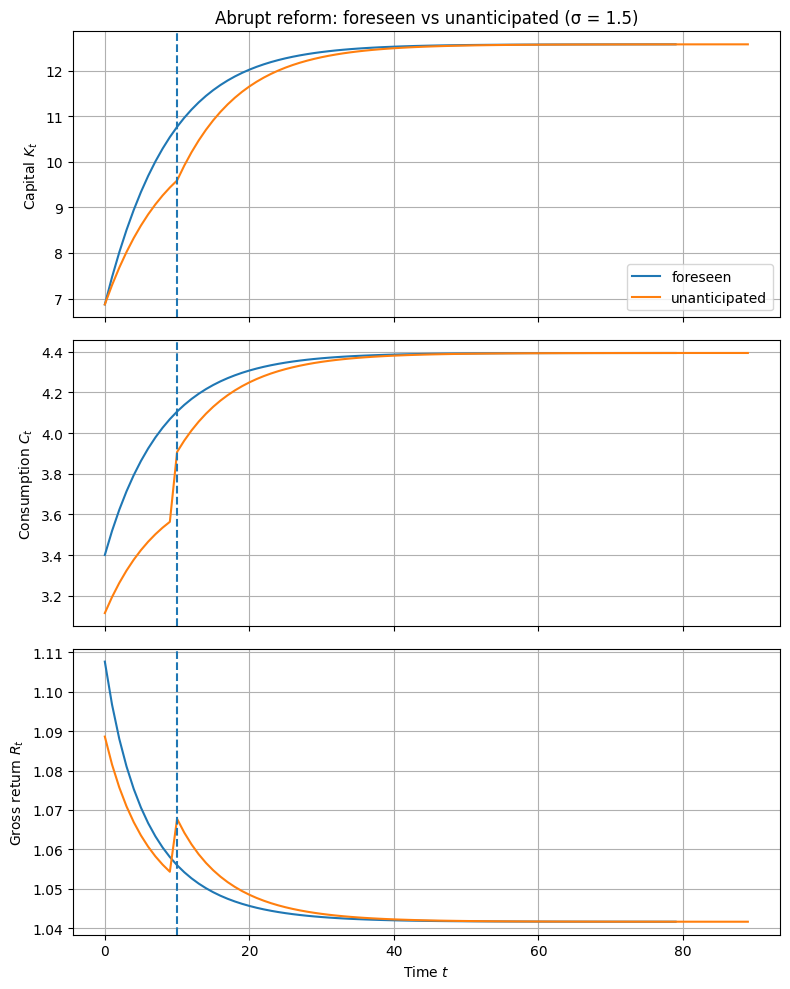

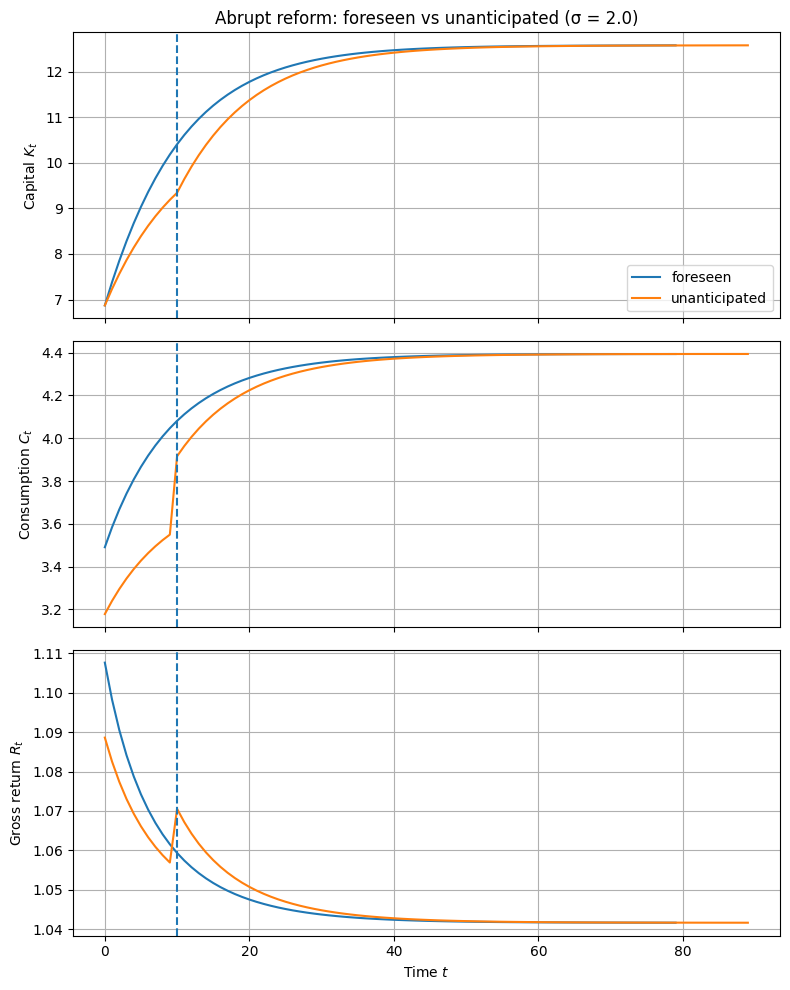

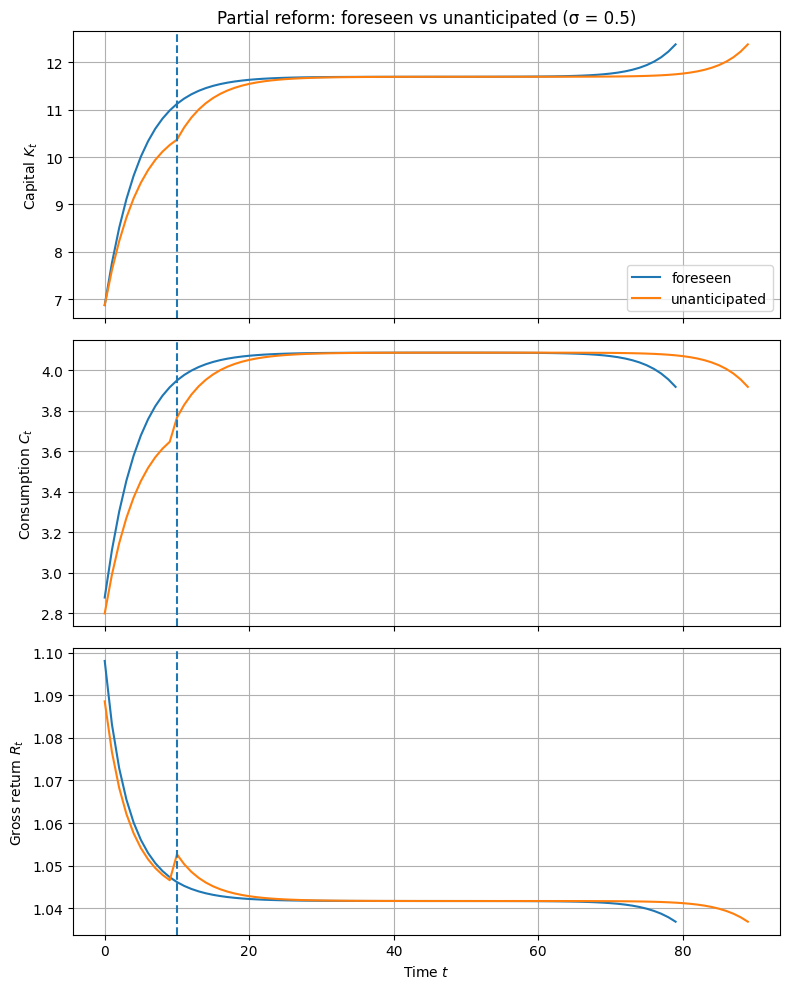

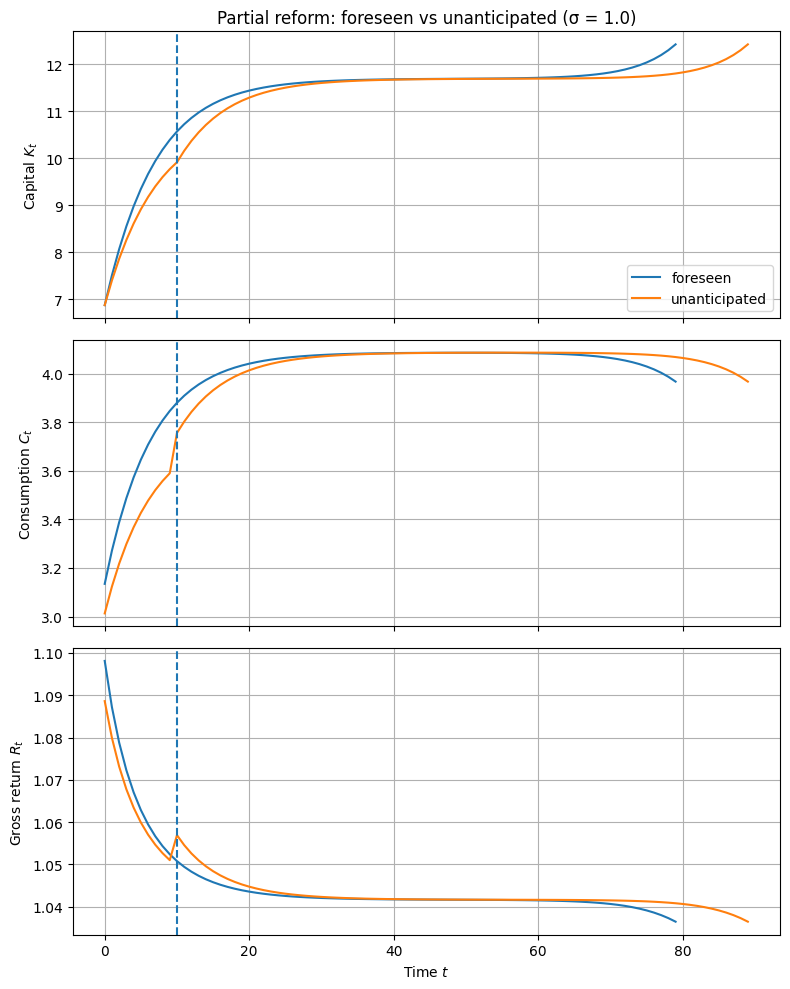

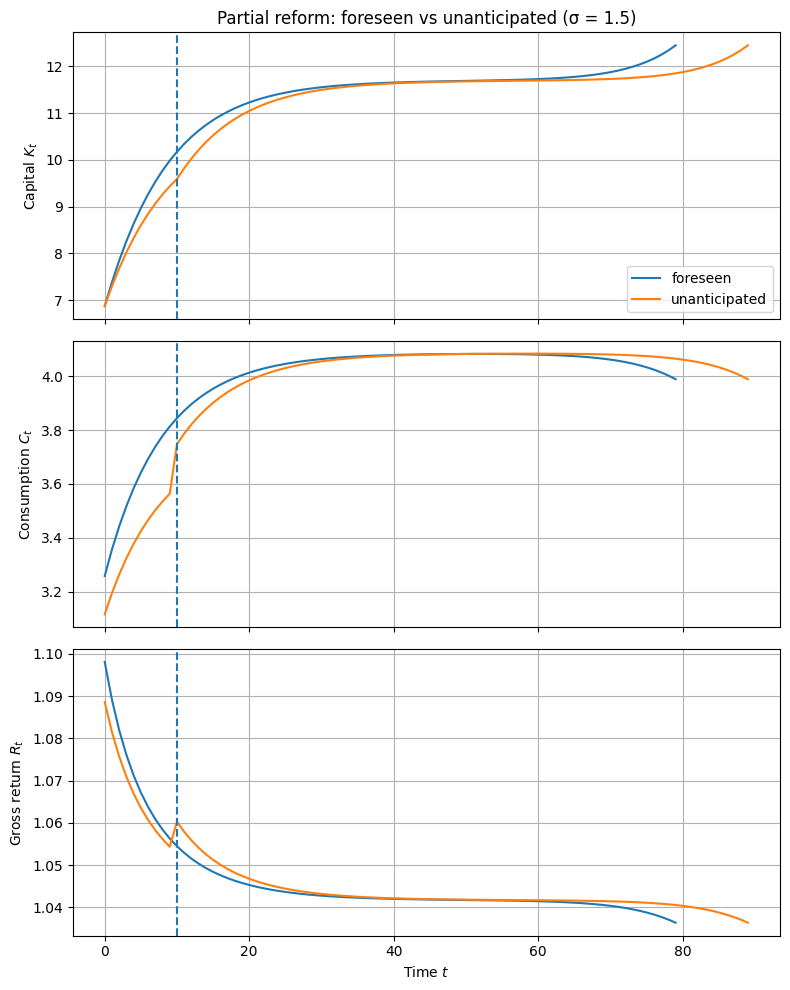

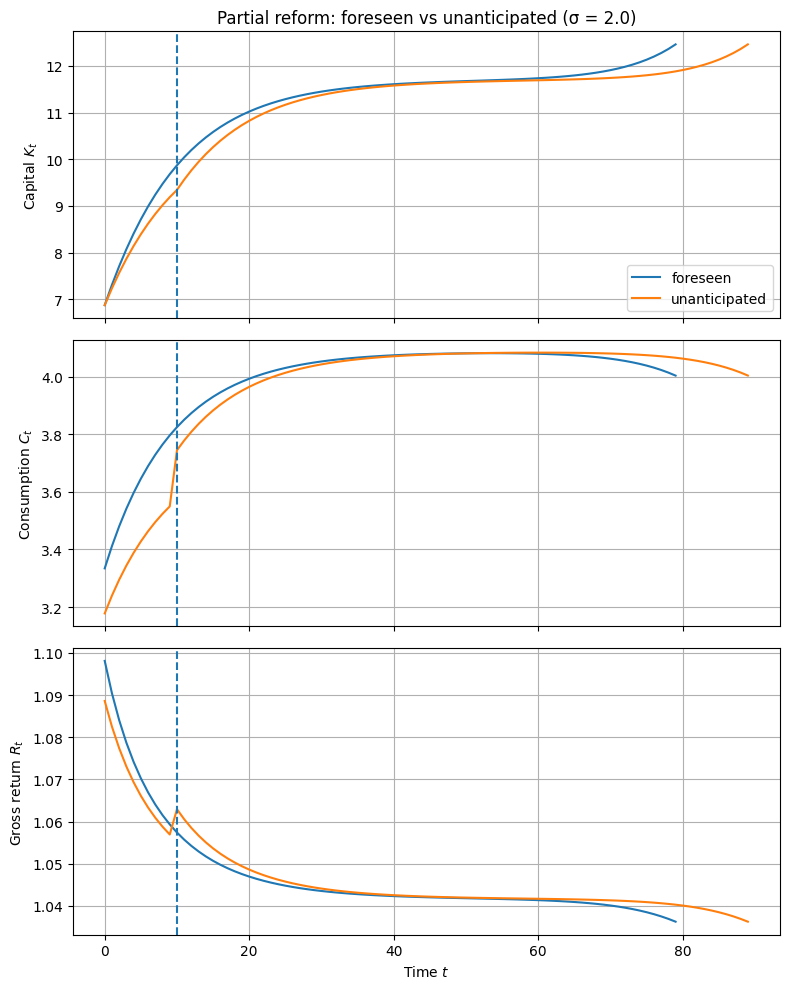

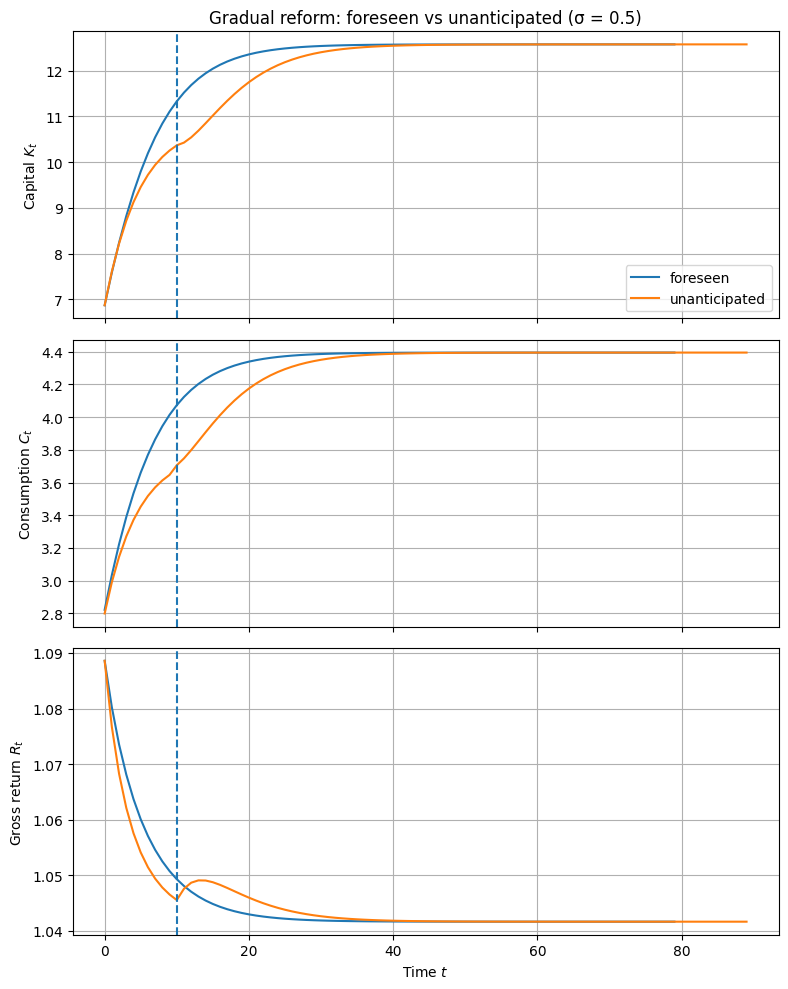

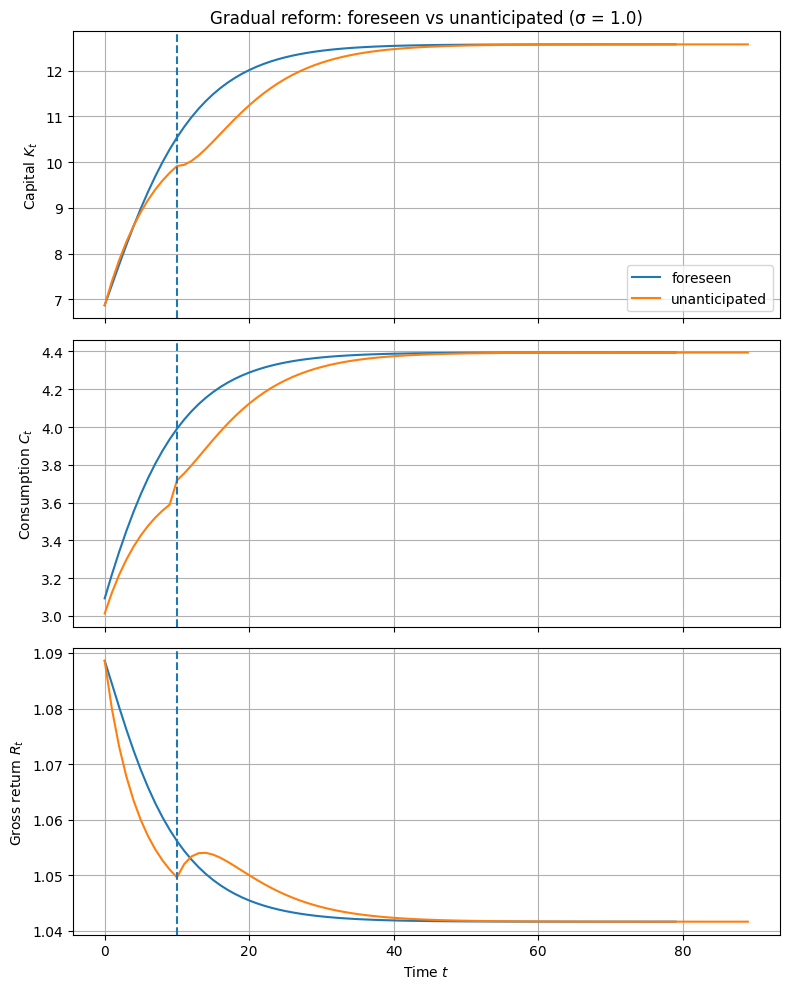

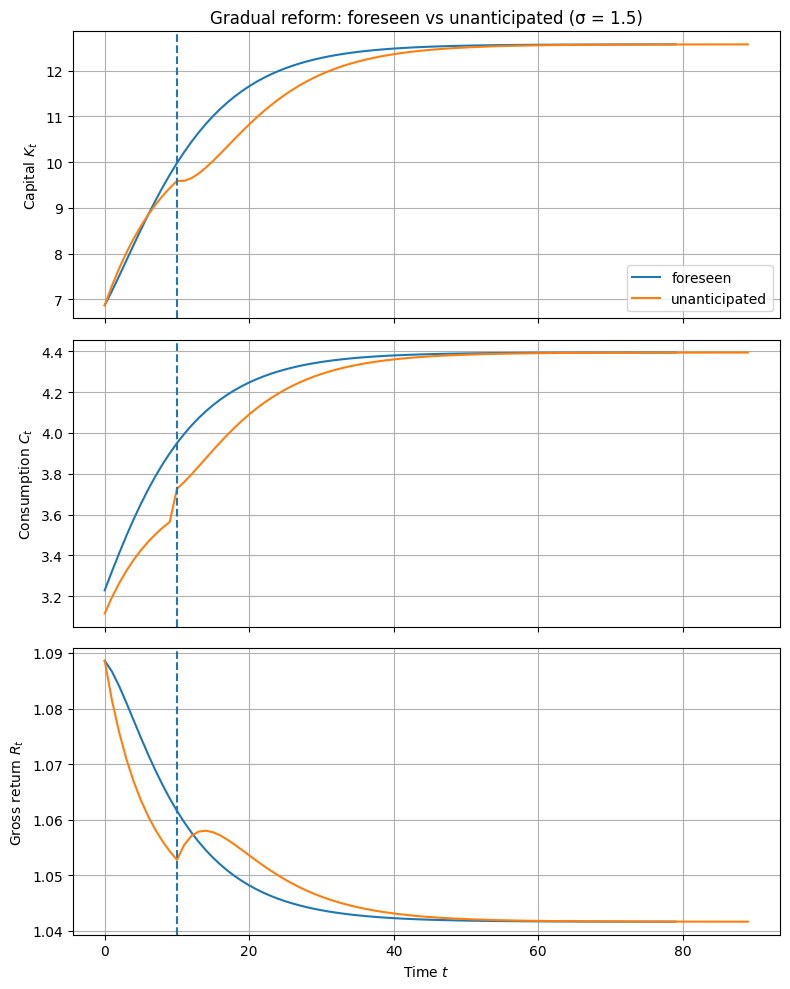

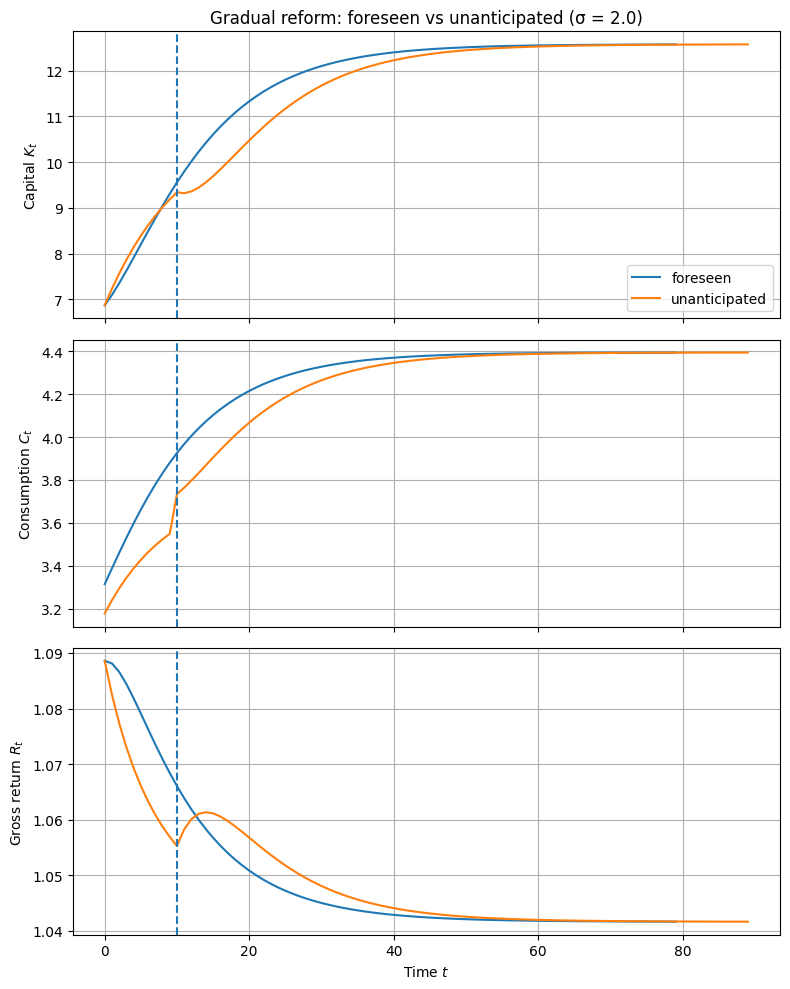

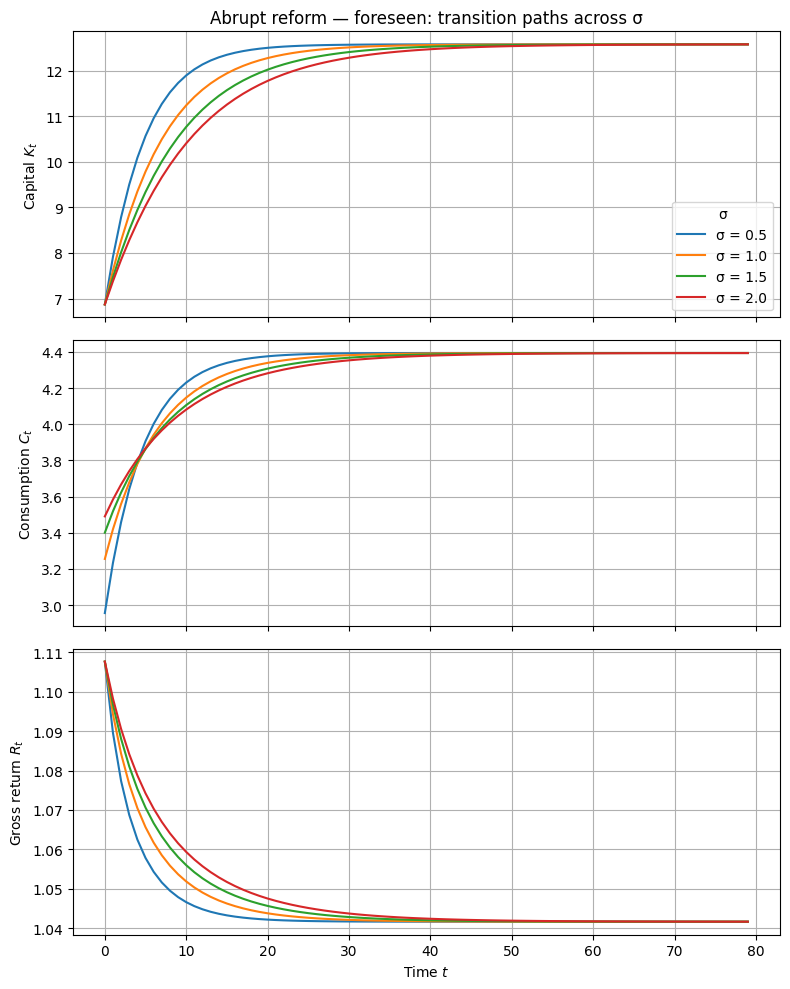

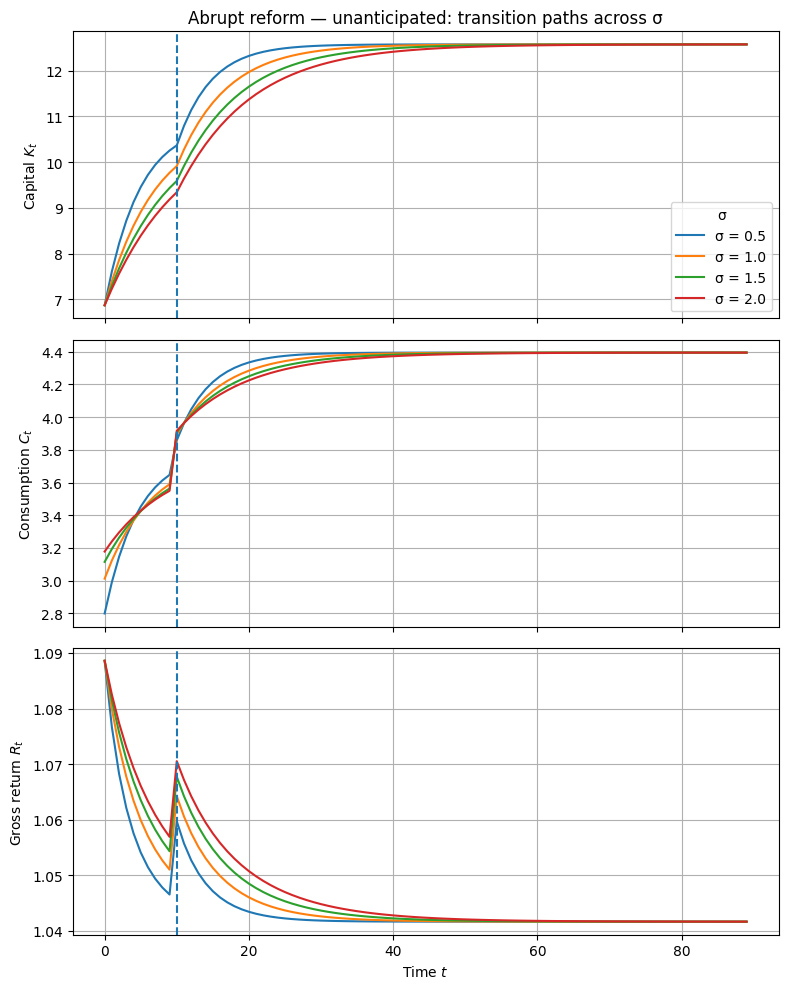

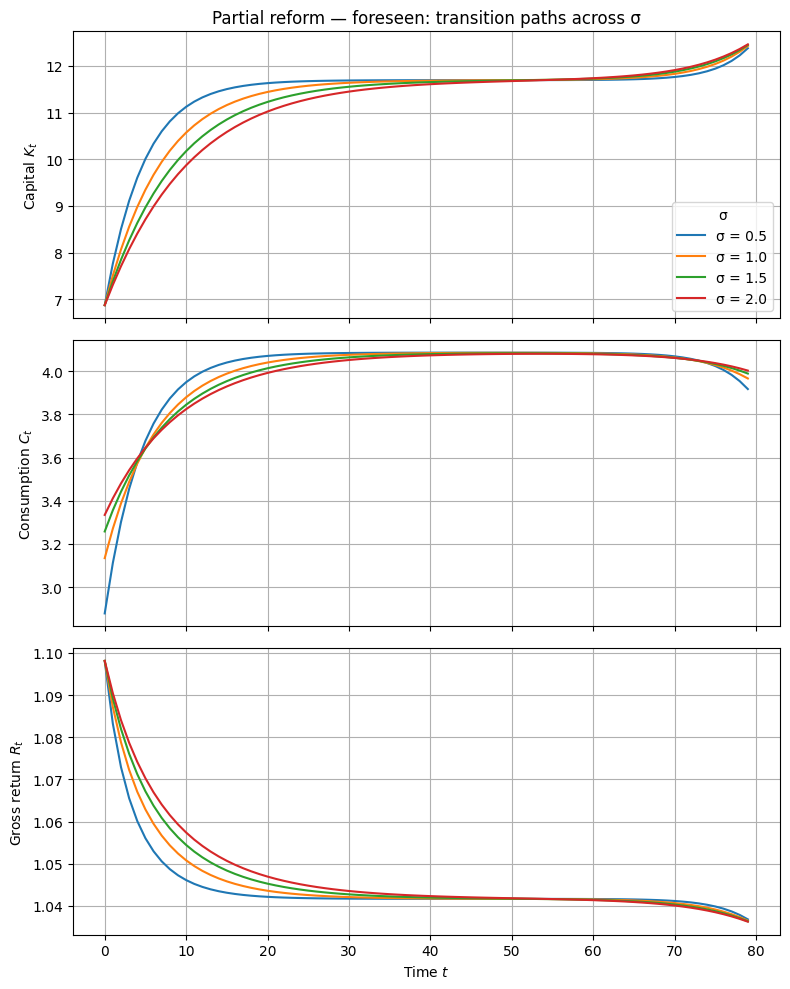

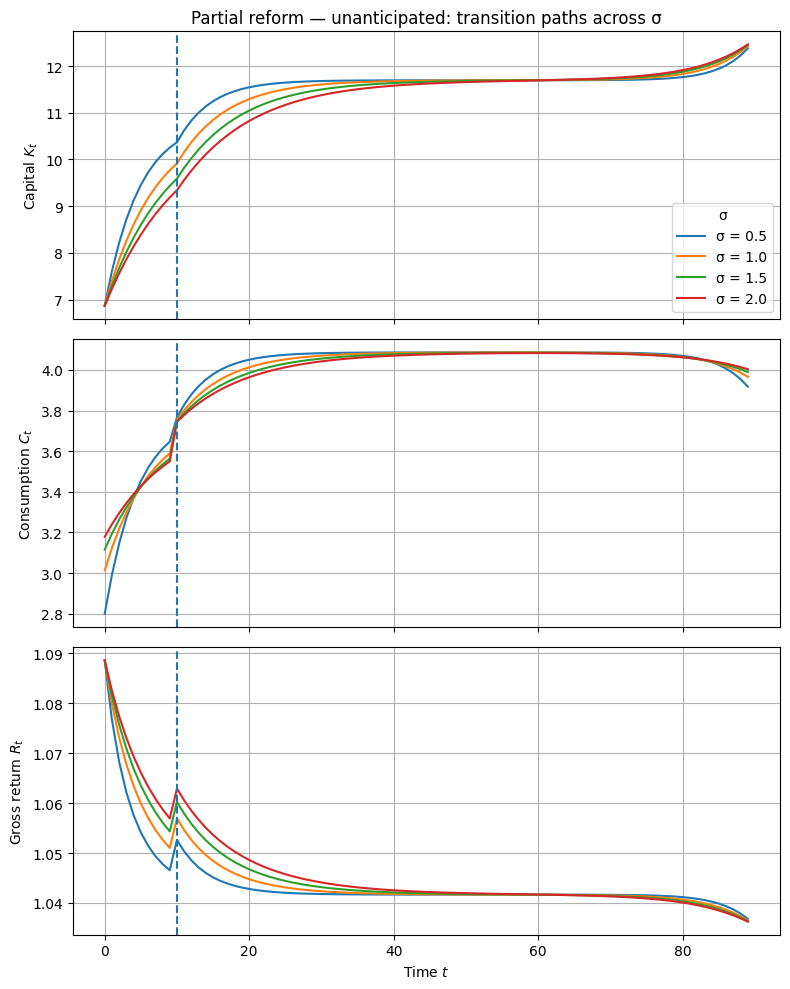

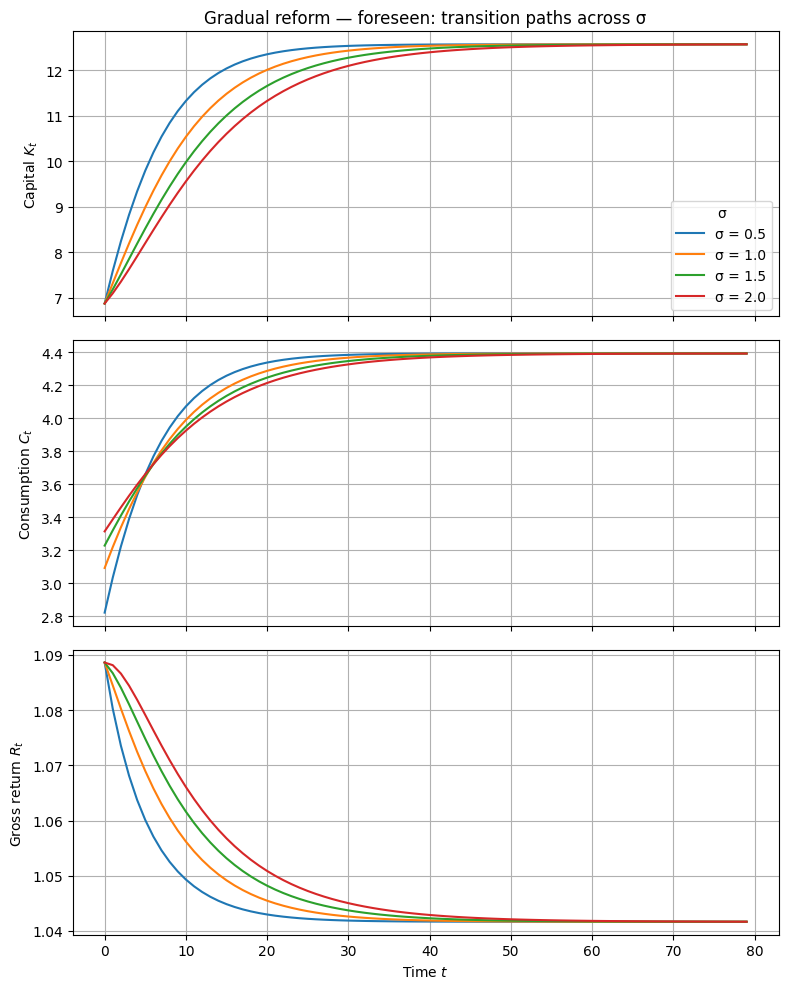

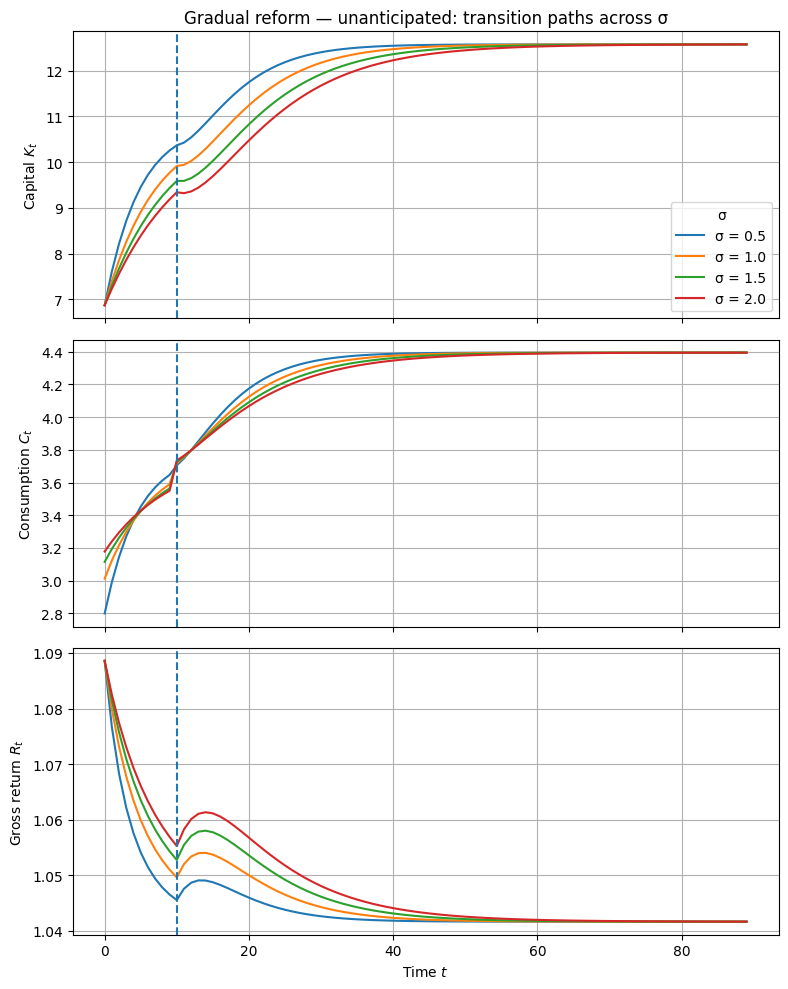

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    sigma_vals
except NameError:
    sigma_vals = [0.5, 1.0, 1.5, 2.0]

try:
    T
except NameError:
    T = 80

try:
    t_shock
except NameError:
    t_shock = 10

try:
    lambda_entry
except NameError:
    lambda_entry = 0.2  # smaller => slower clean

# Build A_t reform paths
A_D = float(distorted["A"])
A_C = float(clean["A"])

# Abrupt
A_post_abrupt = np.full(T, A_C)

# Partial
try:
    eta_partial
except NameError:
    eta_partial = 0.5
A_P = eta_partial * A_C + (1 - eta_partial) * A_D
A_post_partial = np.full(T, A_P)

# Gradual
A_post_gradual = build_A_path_with_entry_exit(A_D, A_C, T, lambda_entry=lambda_entry)

A_pre_flat = np.full(T, A_D)

reform_paths = {
    "abrupt": A_post_abrupt,
    "partial": A_post_partial,
    "gradual": A_post_gradual,
}

rows = []
for sigma in sigma_vals:
    for reform, A_post in reform_paths.items():
        # Foreseen (perfect foresight over A_post)
        sim_fore = simulate_transition(
            cal,
            A_post,
            distorted["K"],
            clean["K"],
            sigma=sigma,
            T=T
        )
        for t in range(len(sim_fore["C"])):
            rows.append({
                "sigma": sigma,
                "reform": reform,
                "information": "foreseen",
                "t": t,
                "K_t": sim_fore["K"][t],
                "C_t": sim_fore["C"][t],
                "R_t": sim_fore["R"][t],
            })

        # Unanticipated
        sim_unant = simulate_unanticipated_shock(
            cal,
            A_pre=A_pre_flat,
            A_post=A_post,
            K0=distorted["K"],
            K_post_ss=clean["K"],
            sigma=sigma,
            t_shock=t_shock
        )
        Tlen = len(sim_unant["C"])
        for t in range(Tlen):
            rows.append({
                "sigma": sigma,
                "reform": reform,
                "information": "unanticipated",
                "t": t,
                "K_t": sim_unant["K"][t],
                "C_t": sim_unant["C"][t],
                "R_t": sim_unant["R"][t],
            })

paths_all_df3 = pd.DataFrame(rows)
display(paths_all_df3.head())

try:
    to_latex_table(
        paths_all_df3.head(20),
        "Sample of transition paths (foreseen vs unanticipated, all reforms)",
        "tab:paths_all_reforms_sample",
        "paths_all_reforms_sample.tex",
        float_format="%.2f",
        index=True
    )
except Exception as e:
    print("LaTeX export skipped (helper not found):", e)

vars_to_plot = ["K_t", "C_t", "R_t"]
var_labels = {
    "K_t": "Capital $K_t$",
    "C_t": "Consumption $C_t$",
    "R_t": "Gross return $R_t$",
}

for reform in ["abrupt", "partial", "gradual"]:
    for sigma in sigma_vals:
        df_sub = paths_all_df3[(paths_all_df3["reform"] == reform) &
                               (paths_all_df3["sigma"] == sigma)]
        fig, axes = plt.subplots(3, 1, figsize=(8, 10), sharex=True)
        for i, var in enumerate(vars_to_plot):
            ax = axes[i]
            for info in ["foreseen", "unanticipated"]:
                df_plot = df_sub[df_sub["information"] == info]
                ax.plot(df_plot["t"], df_plot[var], label=info)
            # shock line only makes sense for unanticipated plots, but harmless to show
            ax.axvline(t_shock, linestyle="--")
            ax.set_ylabel(var_labels[var]); ax.grid(True)
        axes[0].set_title(f"{reform.capitalize()} reform: foreseen vs unanticipated (σ = {sigma})")
        axes[-1].set_xlabel("Time $t$")
        axes[0].legend()
        plt.tight_layout()
        plt.show()

for reform in ["abrupt", "partial", "gradual"]:
    for info in ["foreseen", "unanticipated"]:
        df_sub = paths_all_df3[(paths_all_df3["reform"] == reform) &
                               (paths_all_df3["information"] == info)]
        fig, axes = plt.subplots(3, 1, figsize=(8, 10), sharex=True)
        for i, var in enumerate(vars_to_plot):
            ax = axes[i]
            for sigma in sigma_vals:
                df_plot = df_sub[df_sub["sigma"] == sigma]
                ax.plot(df_plot["t"], df_plot[var], label=f"σ = {sigma}")
            if info == "unanticipated":
                ax.axvline(t_shock, linestyle="--")
            ax.set_ylabel(var_labels[var]); ax.grid(True)
        axes[0].set_title(f"{reform.capitalize()} reform : {info}: transition paths across σ")
        axes[-1].set_xlabel("Time $t$")
        axes[0].legend(title="σ")
        plt.tight_layout()
        plt.show()
